### Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import seaborn as sns

In [3]:
data = pd.read_csv('case1Data.csv')
data

X = copy.copy(data.drop(columns="C_02").iloc[:, 1:])
y = copy.copy(data['y'])

<Axes: >

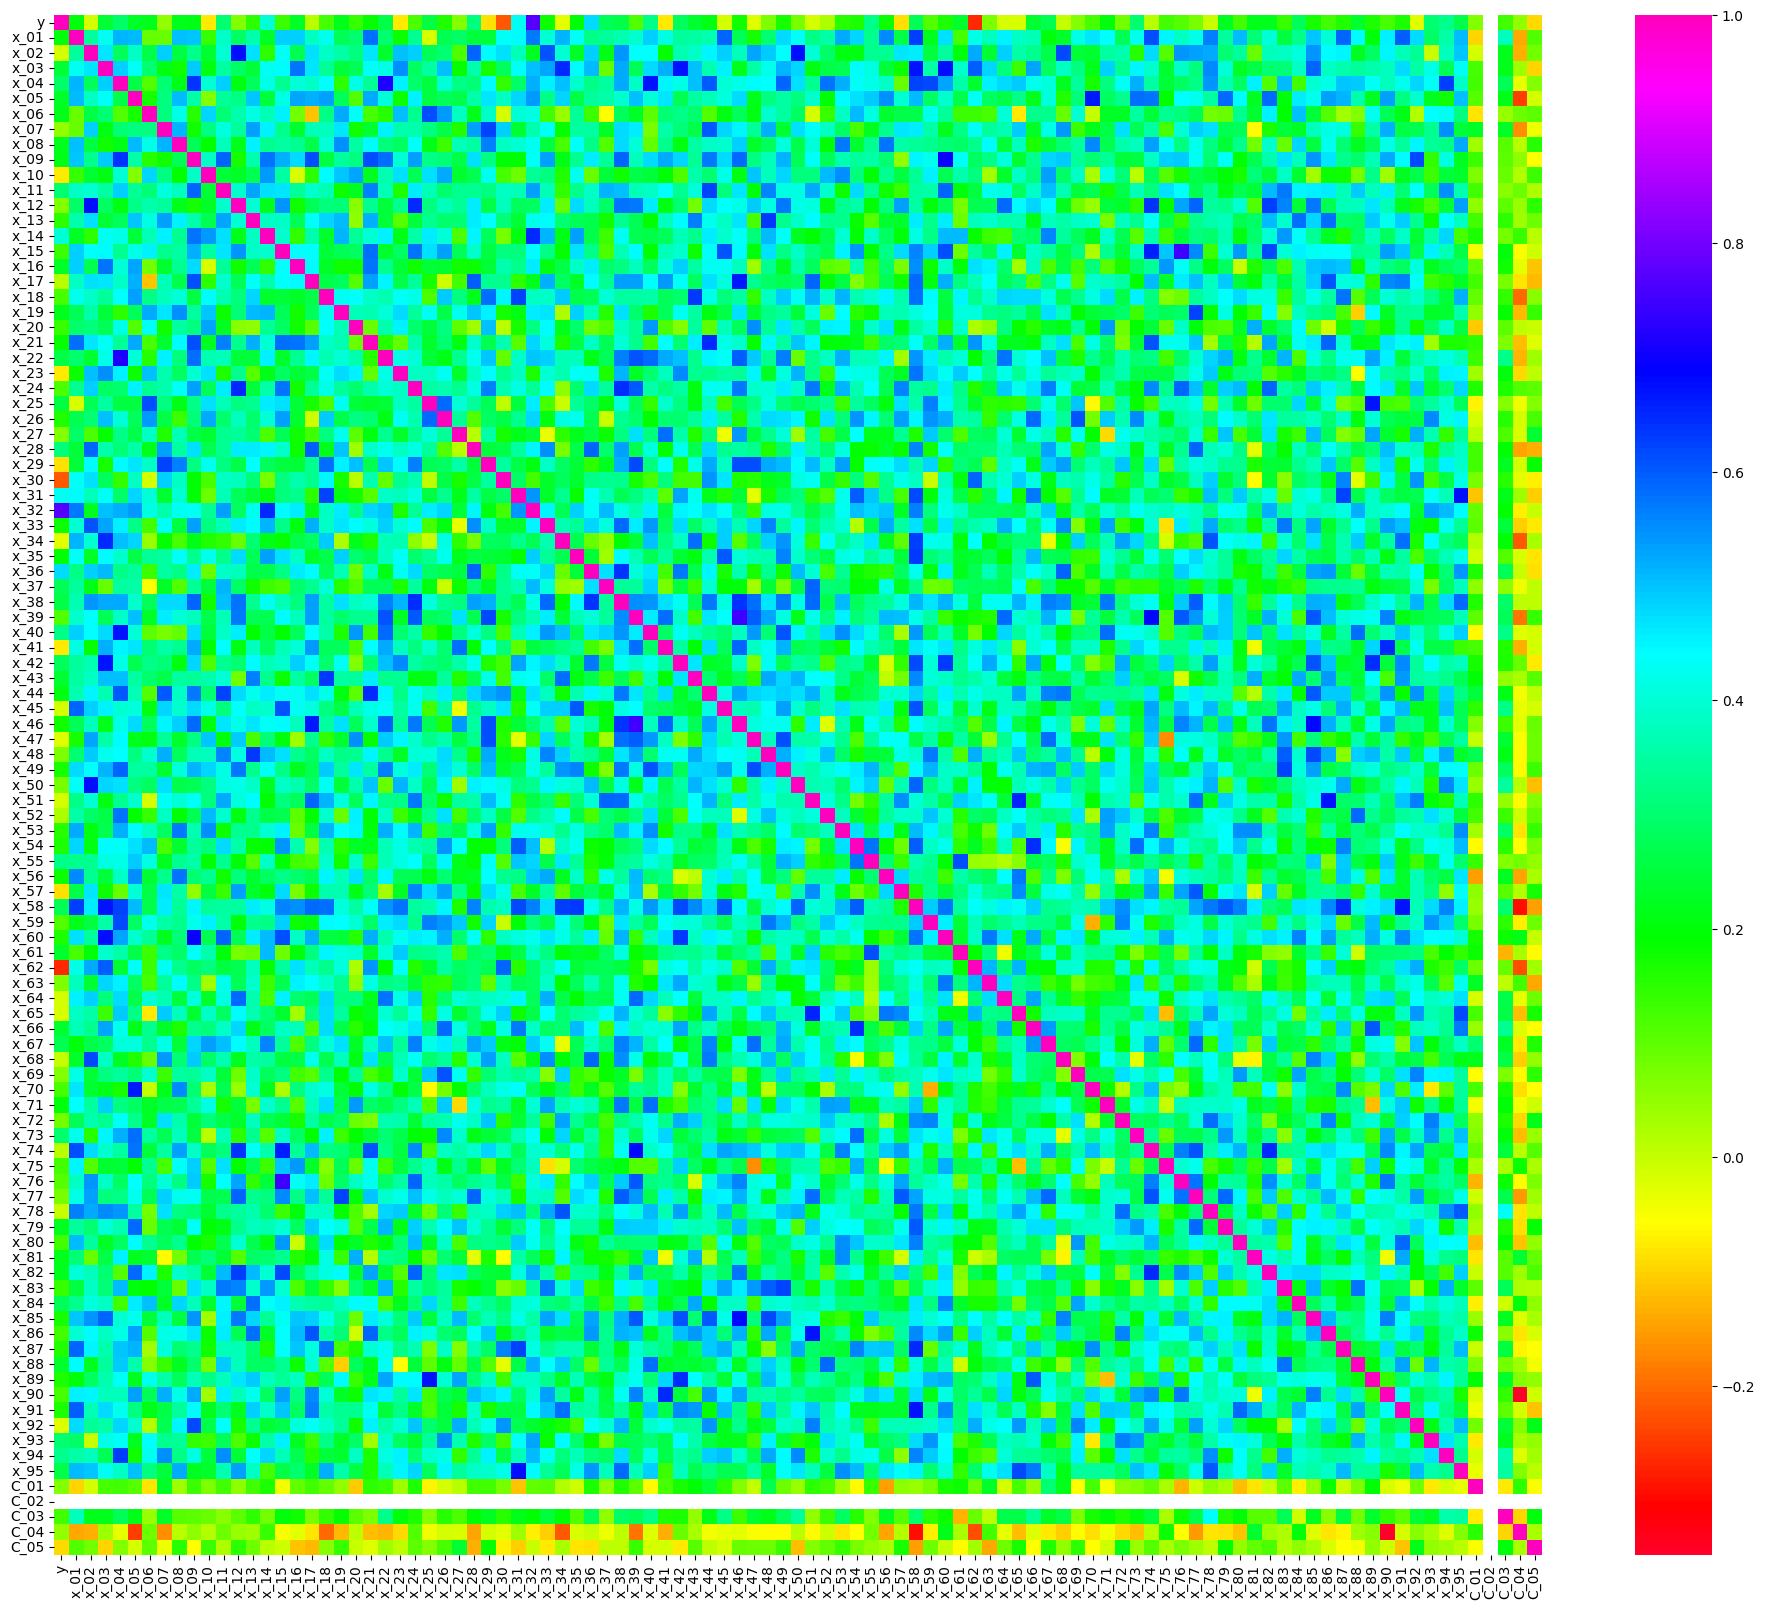

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(24,20))
sns.heatmap(data.corr(), ax=ax, cmap="gist_rainbow")

In [5]:
# Check for columns with only one value
for i in data:
    if data[i].nunique()==1: print(i, "has only one unique value")

C_02 has only one unique value


In [6]:
#check which rows have null values
has_null = (data.isnull().values.any(axis=1), X.isnull().values.sum())[0]
print(f"Rows with null values: {sum(has_null)}/100")

Rows with null values: 100/100


### Initial PCA analysis

In [7]:
from sklearn.decomposition import PCA

In [8]:
n_components = min(X.shape)
# Perform PCA
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Explained variance plot
# fig, ax = plt.subplots(1,1, figsize=(16, 8))
k = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0][0]
plt.plot(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), alpha=0.7, color='b')
plt.vlines(k, 0, 1, color='r')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title(f'Explained Variance by Principal Components (95 at {k})')
plt.show()

n_rows, n_cols = 5, 5
# Scatter plot of first two principal components
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20,20))
for i in range(n_rows):
    for j in range(n_cols):
        
        if i == j:
            ax[i,j].hist(X_pca[:, i])
            pass
        
        else:
            ax[i, j].scatter(X_pca[:, i], X_pca[:, j], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
        
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Projection')

plt.tight_layout()
plt.show()


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [23]:
df_pca = {f'PC{i+1}': X_pca[:, i] for i in range(4)}
g = sns.pairplot(pd.DataFrame(df_pca), diag_kind="kde", corner=False)
g.map_lower(sns.kdeplot, levels=4, color=".2") 

NameError: name 'X_pca' is not defined

## Models

See slide 27 week 2

#### Naive Implementation (not used in report, but implemented to gain understanding)

In [95]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LassoCV
import pandas as pd
import numpy as np

class ImputeData(BaseEstimator, TransformerMixin):
    def __init__(self, num_neighbours: int = 5):
        super().__init__()
        self.num_neighbours = num_neighbours
        self._is_fitted = False
    
    def fit(self, X, y=None):
        # Get category columns and dimension columns
        self.cat_columns = [x for x in X.columns if (x.startswith('C') and (X[x].nunique() != 1))]
        self.dim_columns = [x for x in X.columns if x.startswith('x')]
        
        # Initialize models
        self.normalizer = StandardScaler()
        self.knn_imputer = KNNImputer(n_neighbors=self.num_neighbours)
        self.cat_imputer = SimpleImputer(strategy='most_frequent')

        
        # Fit the KNN imputer, scaler, and the encoder for categorical columns
        X_scaled = pd.DataFrame(self.normalizer.fit_transform(X[self.dim_columns]), columns=self.dim_columns)
        self.knn_imputer.fit(X_scaled)
        self.cat_imputer.fit(X[self.cat_columns])
        self._is_fitted = True
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # Dimension
        X_scaled = pd.DataFrame(self.normalizer.transform(X_transformed[self.dim_columns]), columns=self.dim_columns)
        X_transformed[self.dim_columns] = self.knn_imputer.transform(X_scaled)

        # Category
        X_transformed[self.cat_columns] = self.cat_imputer.transform(X_transformed[self.cat_columns])

        return X_transformed
    
    def __sklearn_clone__(self):
        return ImputeData(self.num_neighbours)
    
    def __sklearn_is_fitted__(self):
        """
        Check fitted status and return a Boolean value.
        """
        return hasattr(self, "_is_fitted") and self._is_fitted
    
class ImputeDataMean(BaseEstimator, TransformerMixin):
    def __init__(self, num_neighbours: int = 5):
        super().__init__()
        self.num_neighbours = num_neighbours
        self._is_fitted = False
    
    def fit(self, X, y=None):
        # Get category columns and dimension columns
        self.cat_columns = [x for x in X.columns if (x.startswith('C') and (X[x].nunique() != 1))]
        self.dim_columns = [x for x in X.columns if x.startswith('x')]
        
        # Initialize models
        # self.normalizer = StandardScaler()
        # self.knn_imputer = KNNImputer(n_neighbors=self.num_neighbours)
        self.dim_imputer = SimpleImputer(strategy='mean')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')

        
        # Fit the KNN imputer, scaler, and the encoder for categorical columns
        # X_scaled = pd.DataFrame(self.normalizer.fit_transform(X[self.dim_columns]), columns=self.dim_columns)
        # self.knn_imputer.fit(X_scaled)
        self.dim_imputer.fit(X[self.dim_columns])
        self.cat_imputer.fit(X[self.cat_columns])
        self._is_fitted = True
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # Dimension
        # X_scaled = pd.DataFrame(self.normalizer.transform(X_transformed[self.dim_columns]), columns=self.dim_columns)
        # X_transformed[self.dim_columns] = self.knn_imputer.transform(X_scaled)
        X_transformed[self.dim_columns] = self.dim_imputer.transform(X_transformed[self.dim_columns])

        # Category
        X_transformed[self.cat_columns] = self.cat_imputer.transform(X_transformed[self.cat_columns])

        return X_transformed
    
    def __sklearn_clone__(self):
        return ImputeData(self.num_neighbours)
    
    def __sklearn_is_fitted__(self):
        """
        Check fitted status and return a Boolean value.
        """
        return hasattr(self, "_is_fitted") and self._is_fitted

class ScaleAndOneHot(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self._is_fitted = False
    def fit(self, X, y=None):
        self.cat_columns = [x for x in X.columns if (x.startswith('C') and (X[x].nunique() != 1))]
        self.dim_columns = [x for x in X.columns if x.startswith('x')]
        
        self.normalizer = StandardScaler()
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        
        self.normalizer.fit(X[self.dim_columns])
        self.encoder.fit(X[self.cat_columns])
        
        self._is_fitted = True
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # Dimension
        X_transformed[self.dim_columns] = self.normalizer.transform(X_transformed[self.dim_columns])
        
        # One hot encode the categorical columns
        X_encoded = self.encoder.transform(X_transformed[self.cat_columns].astype(int))
        encoded_df = pd.DataFrame(X_encoded, columns=self.encoder.get_feature_names_out(self.cat_columns))

        # Drop the original categorical columns and concatenate the encoded ones
        X_transformed = X_transformed.drop(columns=self.cat_columns).reset_index(drop=True)
        X_transformed = pd.concat([X_transformed, encoded_df], axis=1)
        
        return X_transformed
    
    def __sklearn_is_fitted__(self):
        """
        Check fitted status and return a Boolean value.
        """
        return hasattr(self, "_is_fitted") and self._is_fitted

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cv=5):
        super().__init__()
        self.cv = cv  # Regularization strength for Lasso
        self._is_fitted = False
        
    def fit(self, X, y):
        self.lasso = LassoCV(cv=self.cv, max_iter=100_000)
        self.lasso.fit(X, y)
        
        self.selected_features = X.columns[abs(self.lasso.coef_) > 1e-10]
        # self.selected_features = abs(self.lasso.coef_) > 1e-10
        self._is_fitted = True
        return self
    
    def transform(self, X):
        # Check if there are any selected features
        if len(self.selected_features) == 0:
            # Return at least some features if none are selected by Lasso
            print("Warning: No features selected by Lasso. Using all features.")
            return X
        
        X_selected = X[self.selected_features]
        # X_selected = X[:, self.selected_features]
        return X_selected
    
    def __sklearn_clone__(self):
        return FeatureSelector(self.alpha)
    
    def __sklearn_is_fitted__(self):
        """
        Check fitted status and return a Boolean value.
        """
        return hasattr(self, "_is_fitted") and self._is_fitted

class FeatureSelectorPCA(BaseEstimator, TransformerMixin):
    def __init__(self, num_components=None):
        super().__init__()
        self.num_components = None
        self._is_fitted = False
        
    def fit(self, X, y):
        self.pca = PCA(n_components=self.num_components)
        self.pca.fit(X, y)
        
        self._is_fitted = True
        return self
    
    def transform(self, X):
        X_t = self.pca.transform(X)
        X_selected = X_t[:, self.pca.explained_variance_ratio_ > 0.00]
        return X_selected
    
    def __sklearn_clone__(self):
        return FeatureSelector(self.alpha)
    
    def __sklearn_is_fitted__(self):
        """
        Check fitted status and return a Boolean value.
        """
        return hasattr(self, "_is_fitted") and self._is_fitted


In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
from typing import Dict, Any, Tuple, List

from sklearn.pipeline import Pipeline

seed = 42

def train_and_evaluate(models: Dict[str, Any], X: pd.DataFrame, y: pd.DataFrame, n_splits: int = 5, seed: int = 42) -> pd.DataFrame:
    """
    Trains and evaluates multiple models using K-Fold Cross-Validation.

    Args:
        models: A dictionary of model names and models.
        X: Feature matrix.
        y: Target vector.
        n_splits: Number of folds for cross-validation.
        seed: Random seed for reproducibility.

    Returns:
        A DataFrame containing average train/test scores and errors for each model.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Create pipeline that does our data preprocessing
    preprocessor = Pipeline(steps=[
        ('imputer', ImputeData(num_neighbours=5)),
        ('scaler-onehot', ScaleAndOneHot()),
        ('feature-selector', FeatureSelector(cv=5))
    ])
    # preprocessor = Pipeline(steps=[
    #     ('imputer', ImputeData(num_neighbours=5)),
    #     ('scaler-onehot', ScaleAndOneHot()),
    #     ('pca', FeatureSelectorPCA(num_components=None)),
    #     ('lasso', FeatureSelector(alpha=1.0))
    # ])
    # imputer = ImputeData(num_neighbours=5)
    # scaler = ScaleAndOneHot()
    # feat_select = FeatureSelector(alpha=1.0)
    results = []

    for name, model in models.items():
        print(f"Model: {name}")
        model_results = {'model': name, 'train_mse': [], 'test_mse': [], 'train_r2': [], 'test_r2': []}

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
            y_train, y_test = y[train_index], y[test_index]

            # # Impute data
            # X_train = imputer.fit_transform(X_train, y_train)
            # X_test = imputer.transform(X_test)
            
            # # Scale / one-hot encode
            # X_train = scaler.fit_transform(X_train)
            # X_test = scaler.transform(X_test)
            
            # # Feature selection
            # X_train = feat_select.fit_transform(X_train, y_train)
            # X_test = feat_select.transform(X_test)
            # X_train, X_test = feature_selector(X_train, y_train, X_test)
            
            X_train = preprocessor.fit_transform(X_train, y_train)
            X_test = preprocessor.transform(X_test)
            
            # Fit
            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            model_results['train_mse'].append(root_mean_squared_error(y_train, y_train_pred))
            model_results['test_mse'].append(root_mean_squared_error(y_test, y_test_pred))
            model_results['train_r2'].append(r2_score(y_train, y_train_pred))
            model_results['test_r2'].append(r2_score(y_test, y_test_pred))
            # model_results['parameters'].append(model.get_params())
        model_results['params'] = model.get_params()
        results.append({k: np.mean(v) if isinstance(v, list) else v for k, v in model_results.items()})

    return pd.DataFrame(results)


def grid_search(model, param_grid: Dict[str, List[Any]], X: pd.DataFrame, y: pd.DataFrame, n_splits: int = 5, seed: int = 42) -> Tuple[Any, Dict[str, Any], pd.DataFrame]:
    """
    Performs a grid search over hyperparameters and visualizes train/validation curves.

    Args:
        model: The model to tune.
        param_grid: Dictionary of hyperparameters to try.
        X: Feature matrix.
        y: Target vector.
        n_splits: Number of folds for cross-validation.
        seed: Random seed for reproducibility.

    Returns:
        Best estimator, best parameters, and cv_results_ as a DataFrame.
    """
    grid_search = GridSearchCV(model, param_grid, cv=KFold(n_splits=n_splits, shuffle=True, random_state=seed), scoring='neg_root_mean_squared_error', n_jobs=-1, return_train_score=True, verbose=4)
    grid_search.fit(X, y)

    # Convert cv_results_ to a DataFrame for better visualization
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Plotting train vs validation curves if applicable
    if len(param_grid) == 1:  # Only works well if tuning a single hyperparameter
        param_name = list(param_grid.keys())[0]
        plt.figure(figsize=(10, 6))
        plt.plot(results_df[f'param_{param_name}'], -results_df['mean_train_score'], label='Train Score')
        plt.plot(results_df[f'param_{param_name}'], -results_df['mean_test_score'], label='Validation Score')
        plt.xlabel(param_name)
        plt.ylabel('MSE')
        plt.title(f'Train vs. Validation Scores for {model.__class__.__name__}')
        plt.legend()
        plt.show()

    return grid_search.best_estimator_, grid_search.best_params_, results_df


In [249]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
model_dict = {
    # 'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    # 'ElasticNet': ElasticNet(),
    # 'RandomForest': RandomForestRegressor(),
    'GradientBooster': GradientBoostingRegressor(),
    'GradientBooster_mod': GradientBoostingRegressor(loss='absolute_error', learning_rate=0.01, n_estimators=5000, max_depth=2, min_samples_split=10),
    # 'SupportVectorMachine': SVR()
}

results = train_and_evaluate(model_dict, X, y, n_splits=5, seed=42)
results

Model: Ridge
Model: Lasso
Model: GradientBooster
Model: GradientBooster_mod


,model,train_mse,test_mse,train_r2,test_r2,params
0,Ridge,13.692282,27.705340,0.960840,0.833454,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
1,Lasso,15.917471,26.247205,0.949679,0.853235,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
2,GradientBooster,1.431839,40.753769,0.999586,0.660404,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ..."
3,GradientBooster_mod,16.449612,37.239553,0.947144,0.723179,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ..."


In [ ]:
# Grid search
clf = SVR()
pipeline = Pipeline(steps=[
    ('imputer', ImputeData(num_neighbours=5)),
    ('scaler-onehot', ScaleAndOneHot()),
    ('feature-selector', FeatureSelector(cv=10)),
    ('clf', clf)
])

param_grid = {
    
}


In [27]:
pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

,x_01,x_02,x_03,x_04,x_05,x_06,x_07,x_08,x_09,x_10,...,x_90,x_91,x_92,x_93,x_94,x_95,C_01,C_03,C_04,C_05
0,1.235121,-1.157874,0.544559,-0.196505,0.739126,NaN,-1.267505,-0.088128,0.890607,-1.872220,...,0.766721,0.910154,-0.744326,-0.025149,-1.657137,NaN,0.730922,-0.587632,-0.239309,0.113961
1,0.373942,0.771685,0.346713,NaN,0.618696,1.794512,-0.056809,0.107491,1.987403,0.689338,...,1.629593,1.083679,NaN,0.628554,0.503820,-0.598218,0.730922,-0.587632,-0.239309,0.113961
2,0.859792,-0.646953,0.931614,0.388823,0.349191,-0.325934,-1.407273,NaN,0.618269,0.553262,...,-1.782866,-0.709942,1.530380,NaN,NaN,-0.198588,0.000000,1.630204,0.478618,0.854704
3,0.566751,2.348837,1.151684,-1.289973,0.648579,0.362457,-0.177802,-1.515847,-1.132512,-0.251270,...,0.172435,0.576395,-1.478469,-1.510393,0.058571,NaN,-1.461843,0.151647,-1.675162,-0.626783
4,0.111569,0.752643,-0.948928,NaN,-0.835720,0.286759,0.154371,0.129993,0.844057,0.519205,...,-0.064305,1.318265,0.247186,0.564698,0.880782,-0.245405,-0.730922,-0.587632,0.478618,1.595448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.944462,-1.266165,-2.349563,-0.613526,-1.304468,-1.683313,-0.443858,-0.413209,-1.851553,-1.231702,...,-1.249653,-0.560067,-1.538482,-1.886304,-0.084567,-1.728502,0.730922,0.151647,-0.957235,0.113961
96,-0.451617,-1.544033,NaN,-0.711718,0.136945,NaN,-0.881154,0.409999,-0.414301,0.354583,...,NaN,-2.423057,-0.794111,-0.754853,-1.054333,-1.515910,-0.730922,0.151647,-1.675162,0.113961
97,-2.342336,0.384145,-2.025080,-1.480860,-0.479763,NaN,0.730490,-1.252015,-1.225235,-0.139264,...,-1.026954,-2.502152,NaN,-1.559203,-0.174090,NaN,0.730922,0.151647,0.478618,0.113961
98,-0.722489,0.244867,-0.951559,0.568608,0.613161,0.862172,1.154689,-0.490933,-0.489844,1.359320,...,NaN,-1.977414,NaN,-0.752494,0.264195,0.155121,1.461843,0.890925,-0.957235,0.113961


## PCA on transformed data

In [83]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV

lassoCV = LassoCV(cv=15, max_iter=10000)
pca = PCA()
preprocessor = Pipeline(steps=[
        ('imputer', ImputeData(num_neighbours=5)),
        ('scaler-onehot', ScaleAndOneHot())
        ])

X_t = preprocessor.fit_transform(X)

X_pca = pca.fit_transform(X_t)
X_pca.shape

(100, 100)

In [84]:
lassoCV.fit(X_t, y)
lassoCV.coef_

array([  0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,  -0.        ,  -0.        ,   0.        ,
        -2.47948491,  -7.44300723,  -0.        ,  -0.        ,
         4.47448645,   0.        ,   0.        ,   0.        ,
        -0.        ,   0.        ,   0.        ,   0.71701113,
         0.        ,   0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,   0.55138752,
        -4.39002597,  -0.        ,   0.        ,  62.50697778,
        -0.        ,  -0.        ,   1.86269288,  26.28229735,
        -1.96506326,  -0.        ,  -0.        ,   0.        ,
        -2.61731805,  -0.        ,   0.        ,   0.        ,
        -3.58156836,  -0.        ,   0.        ,  -1.38165189,
         6.66477361,   0.        ,  -2.51040864,  -0.        ,
        -0.        ,  -8.3293692 ,   0.        ,   0.        ,
        -7.20767969,   0.        ,   4.70419589,  -0.        ,
         0.38188222, -24.36747193,   0.        ,  -1.57

In [85]:
lassoCV.coef_.shape

(115,)

In [ ]:

X_t.columns[pca.explained_variance_ratio_ > 0.01]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 115 but corresponding boolean dimension is 100

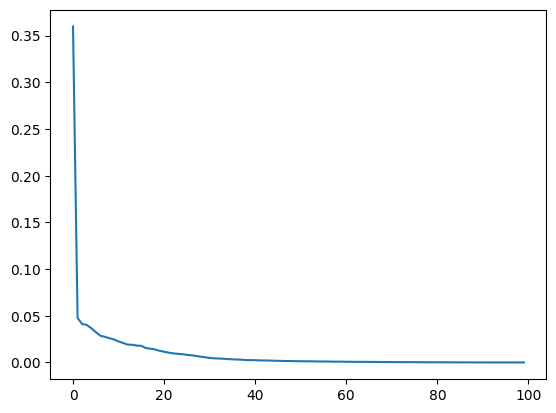

In [45]:
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)   

## Delete this??

In [ ]:
imputer = ImputeData(num_neighbours=5)
imputer.fit(X, y)
X_new = imputer.transform(X)

scaler = ScaleAndOneHot()
scaler.fit(X_new, y)
X_new = scaler.transform(X_new)

feat_select = FeatureSelector(alpha=1.0)
feat_select.fit(X_new, y)
X_new = feat_select.transform(X_new)

X_new

,x_09,x_10,x_13,x_20,x_23,x_28,x_29,x_30,x_32,x_33,...,x_66,x_68,x_75,x_76,x_78,x_81,x_82,x_83,x_86,C_01_71.0
0,0.916140,-1.977093,-0.008827,-1.513053,-0.765640,0.496396,-2.109862,0.125068,1.667124,0.005209,...,0.470130,0.124147,1.771389,0.737293,-0.187635,-0.566901,1.632780,-0.213361,0.054787,0.0
1,2.042756,0.706751,1.322472,1.055499,0.851881,0.117889,0.761848,-0.221156,0.620033,0.988352,...,0.322963,0.368401,1.118097,1.759871,-1.926801,1.157591,1.494040,0.831001,0.719236,0.0
2,0.636398,0.564179,0.579560,-0.494724,-0.761673,-0.770066,-0.460252,-0.551581,0.176995,-1.999445,...,0.135205,-0.816110,1.287507,-1.765628,-0.882866,0.316724,-1.521655,-0.048804,0.441240,0.0
3,-1.161982,-0.278760,0.446962,-0.689285,-0.313034,1.081658,-0.975102,0.369923,0.959925,1.624850,...,-0.323113,0.795710,-1.224390,0.464908,0.248414,-1.388137,1.218419,0.060958,0.380849,1.0
4,0.868325,0.528496,1.610542,-0.916011,-0.515144,1.218053,0.524255,-0.071638,1.405125,-0.022506,...,-0.479527,0.726197,1.675874,-0.720593,0.013632,0.300043,-0.018606,-0.431529,1.857125,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.900572,-1.305997,-1.139331,-0.786606,-0.863825,-1.276283,-1.508877,-0.988121,-2.547933,-0.328425,...,-2.293085,-2.096600,-1.419832,-2.417310,-0.419632,-0.629506,-3.634348,-0.298719,-2.228827,0.0
96,-0.424244,0.356016,-1.644223,0.226611,-0.097715,-1.459150,-0.311664,-0.659833,-0.913928,-1.410116,...,-0.223366,-0.579047,0.219901,-0.891557,-0.563317,-1.618446,-1.142223,-1.138199,-0.863971,0.0
97,-1.257226,-0.161408,-0.886100,-1.221649,0.433715,-0.829918,1.276442,1.004938,-1.489313,-0.569798,...,-0.260415,0.685940,-1.418100,-1.017386,-0.421573,-0.442163,-1.017557,0.472690,-0.341882,0.0
98,-0.501841,1.408717,0.902407,0.970181,0.451519,0.412705,2.280481,-0.084708,0.330695,0.920555,...,1.424493,0.430143,-1.355372,-0.913202,-0.334258,-0.949446,0.488202,0.731041,-0.458873,0.0


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.utils.validation import check_is_fitted

data = pd.read_csv('case1Data.csv')

X = copy.copy(data.drop(columns="C_02").iloc[:, 1:])
y = copy.copy(data['y'])

# PreprocessData, FeatureSelector
pipeline = Pipeline(steps=[
    ('imputer', ImputeData(num_neighbours=5)),
    ('scale_and_onehot', ScaleAndOneHot()),
    ('Feature_selector', FeatureSelector()),
    ('model', SVR())
])

param_grid_SVR = {
    'imputer__num_neighbours': [5],
    'model__C': 1 / np.logspace(-3, 3, num=7, base=10),
    'model__kernel': ['rbf'],
    'model__epsilon': [0.001, 0.01, 0.1],
    'model__shrinking': [False]
              }

param_grid_Ridge = {
    'model__alpha': np.logspace(-3, 3, num=500, base=10)
}

K = 15
grid_search = GridSearchCV(pipeline, param_grid_SVR, cv=K, n_jobs=-1, verbose=4, scoring='neg_root_mean_squared_error', refit=True, return_train_score=False)

# Fit the model with GridSearchCV
grid_search.fit(X, y)
print('Done fitting')
# Use the best model to make predictions
best_model = grid_search.best_estimator_
# Check the best parameters and model
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Check if all steps are fitted
check_is_fitted(best_model.named_steps['imputer'])  
check_is_fitted(best_model.named_steps['scale_and_onehot'])
check_is_fitted(best_model.named_steps['Feature_selector'])
check_is_fitted(best_model.named_steps['model'])

# y_pred = best_model.predict(X_test)
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

Fitting 15 folds for each of 21 candidates, totalling 315 fits
Best parameters: {'imputer__num_neighbours': 5, 'model__C': 1000.0, 'model__epsilon': 0.001, 'model__kernel': 'rbf', 'model__shrinking': False}
Best score: -41.13889438104328


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_imputer__num_neighbours,param_model__C,param_model__epsilon,param_model__kernel,param_model__shrinking,params,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.293809,0.060963,0.178782,0.042976,5,1000.000,0.001,rbf,False,"{'imputer__num_neighbours': 5, 'model__C': 100...",...,-57.854645,-30.018511,-63.148836,-44.159493,-29.825529,-44.339710,-28.663980,-41.138894,13.365405,1
1,0.304465,0.054754,0.190258,0.030908,5,1000.000,0.010,rbf,False,"{'imputer__num_neighbours': 5, 'model__C': 100...",...,-57.855855,-30.021160,-63.152809,-44.161120,-29.824811,-44.340589,-28.663330,-41.139696,13.365878,2
2,0.284182,0.031913,0.175429,0.021462,5,1000.000,0.100,rbf,False,"{'imputer__num_neighbours': 5, 'model__C': 100...",...,-57.868373,-30.047264,-63.192351,-44.177308,-29.817970,-44.350764,-28.655091,-41.147537,13.370763,3
3,0.303188,0.051489,0.196432,0.052670,5,100.000,0.001,rbf,False,"{'imputer__num_neighbours': 5, 'model__C': 100...",...,-58.172304,-35.089501,-67.113866,-45.462747,-28.244926,-46.156709,-26.484704,-42.718141,14.210903,4
4,0.295194,0.036360,0.211387,0.039221,5,100.000,0.010,rbf,False,"{'imputer__num_neighbours': 5, 'model__C': 100...",...,-58.173304,-35.089529,-67.116101,-45.462859,-28.245379,-46.158366,-26.484281,-42.718478,14.211368,5
5,0.344056,0.053877,0.235301,0.044589,5,100.000,0.100,rbf,False,"{'imputer__num_neighbours': 5, 'model__C': 100...",...,-58.183922,-35.089582,-67.140322,-45.463683,-28.249627,-46.177945,-26.479516,-42.722202,14.216437,6
6,0.361727,0.067502,0.249354,0.088727,5,10.000,0.001,rbf,False,"{'imputer__num_neighbours': 5, 'model__C': 10....",...,-70.267628,-61.087133,-101.022093,-65.151247,-51.059118,-64.018863,-35.293562,-63.222470,17.396975,8
7,0.346492,0.078217,0.212542,0.068614,5,10.000,0.010,rbf,False,"{'imputer__num_neighbours': 5, 'model__C': 10....",...,-70.267050,-61.086864,-101.022892,-65.149314,-51.060081,-64.016420,-35.292237,-63.222421,17.397985,7
8,0.339787,0.049195,0.193887,0.033627,5,10.000,0.100,rbf,False,"{'imputer__num_neighbours': 5, 'model__C': 10....",...,-70.260518,-61.084526,-101.028975,-65.130271,-51.070007,-63.993350,-35.278407,-63.222471,17.407116,9
9,0.292294,0.048887,0.175744,0.026504,5,1.000,0.001,rbf,False,"{'imputer__num_neighbours': 5, 'model__C': 1.0...",...,-71.299216,-68.390405,-105.448228,-71.268788,-59.377586,-70.736210,-42.209368,-69.768677,16.921812,10


In [174]:
pipeline.fit(X, y)

NameError: name 'pipeline' is not defined

In [6]:
best_model_cv_results = cv_results.loc[
    cv_results['param_model__epsilon'] == 0.01
]

x_param_name = 'param_model__C'

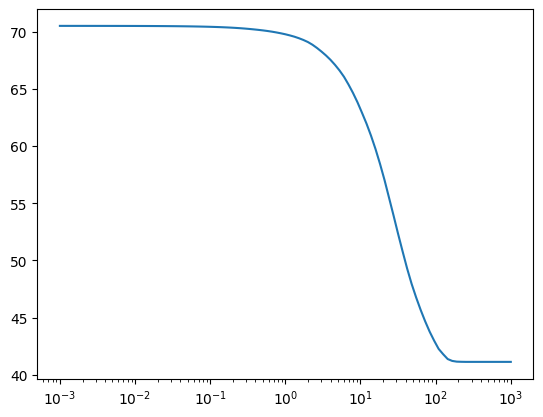

In [7]:
plt.plot(best_model_cv_results[x_param_name], -best_model_cv_results['mean_test_score'])
# plt.plot(cv_results['param_model__alpha'], cv_results['mean_train_score'])
plt.xscale('log')

CV alpha with 1-std-rule 72.44


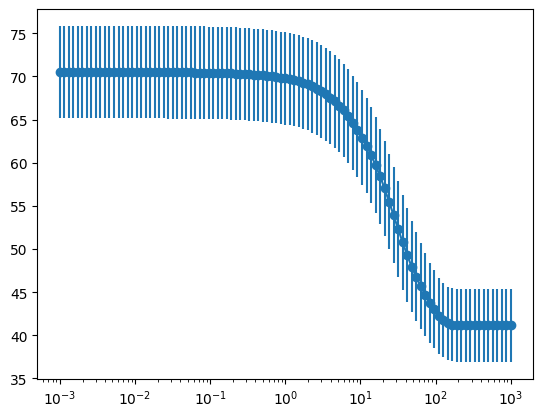

In [8]:
alphas = best_model_cv_results[x_param_name].to_numpy()
meanMSE = -best_model_cv_results['mean_test_score'].to_numpy()
seMSE = best_model_cv_results['std_test_score'].to_numpy() / np.sqrt(10)  # K = 10 folds
jOpt = np.argsort(meanMSE)[0]

J = np.where(meanMSE[jOpt] + seMSE[jOpt] > meanMSE)[0]
j = int(J[-1])
alpha_CV_1StdRule = alphas[j]
print("CV alpha with 1-std-rule %0.2f" % alpha_CV_1StdRule)

plt.xscale('log')
plt.scatter(alphas, meanMSE);
plt.errorbar(alphas, meanMSE, seMSE);

### Estimate RMSE and get predictions

In [180]:
best_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('pre-scale',
                                                                   StandardScaler()),
                                                                  ('num_imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['x_01', 'x_02', 'x_03',
                                                   'x_04', 'x_05', 'x_06',
                                                   'x_07', 'x_08', 'x_09',
                                                   'x_10', 'x_11', 'x_12',
                                                   'x_13', 'x_14', 'x_15',
                                                   'x_16', 'x_17', 'x_18',
                                                   'x_19', 'x_20', 'x_21',
                                                   'x_22', 'x_23', 'x_24',
                                                   'x_25', 'x_26', 'x_27',
                                                   'x_28', 'x_29', 'x_30', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['C_01', 'C_03', 'C_04',
                                                   'C_05'])])),
                ('feature_selection',
                 SelectFromModel(estimator=Lasso(alpha=1))),
                ('clf', Lasso(alpha=0.5956621435290109))])

In [ ]:
dataNEW = pd.read_csv('case1Data_Xnew.csv')
X_NEW = copy.copy(dataNEW.drop(columns="C_02"))

In [42]:
X_NEW

,x_01,x_02,x_03,x_04,x_05,x_06,x_07,x_08,x_09,x_10,...,x_90,x_91,x_92,x_93,x_94,x_95,C_01,C_03,C_04,C_05
0,-0.843969,-9.104918,-5.076919,-4.222152,3.606609,-4.505494,-11.481997,16.201722,15.939470,NaN,...,-2.929719,-13.884702,7.465161,-4.667464,3.949705,-10.715577,73.0,73.0,75.0,73.0
1,0.802093,-10.196678,-4.500370,-7.827837,5.199002,NaN,-15.928708,20.151309,13.707194,-8.517576,...,-5.628246,-14.937164,5.229448,-6.927970,3.271193,-12.420893,73.0,73.0,71.0,75.0
2,4.234883,-10.798261,-0.465914,-6.054850,NaN,NaN,-16.182312,16.419564,12.152861,-6.418069,...,-1.506622,-11.058964,4.692879,-0.929818,NaN,-14.551448,NaN,73.0,71.0,73.0
3,7.041336,-5.169413,-4.158334,-4.270638,14.939894,0.008338,-10.556799,NaN,14.180830,NaN,...,6.157743,NaN,7.460901,-2.484389,8.149697,-11.598544,72.0,74.0,75.0,75.0
4,1.135564,-12.048088,-4.828939,-6.565217,7.493100,-2.789944,-15.859234,21.560086,14.147759,-4.848519,...,-2.424076,-9.607803,5.654679,-3.020357,3.030958,-13.320599,72.0,71.0,74.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,-10.333885,-4.882893,-5.001330,14.740750,-7.375751,-14.269895,NaN,18.944182,-3.516163,...,2.279353,-15.231878,NaN,NaN,2.773400,-8.033125,73.0,71.0,74.0,NaN
996,-0.301550,-9.275305,NaN,-9.984508,5.443650,-5.003200,-13.199856,22.410145,12.723149,-5.684371,...,-1.847770,-13.423383,4.090021,-5.349963,3.544913,-10.234976,72.0,73.0,74.0,NaN
997,3.671630,-6.533390,-0.489830,-5.143861,13.761843,-8.637093,NaN,24.973347,13.576836,-3.389953,...,3.694392,-10.147875,8.668706,-4.411021,-0.860737,-7.109857,72.0,71.0,75.0,NaN
998,2.356294,-4.169392,-2.274090,-2.484517,10.591025,2.055309,-9.804748,15.946822,11.053100,-3.986907,...,3.418046,-11.107330,4.475155,-2.621623,8.438770,-7.255016,72.0,71.0,71.0,73.0


In [56]:
best_model[:-1]#.fit(X,y)

Pipeline(steps=[('imputer', ImputeData()),
                ('scale_and_onehot', ScaleAndOneHot()),
                ('Feature_selector', FeatureSelector())])

In [51]:
best_model['Feature_selector'].selected_features

Index(['x_09', 'x_10', 'x_13', 'x_20', 'x_23', 'x_28', 'x_29', 'x_30', 'x_32',
       'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_41', 'x_45', 'x_48', 'x_49',
       'x_51', 'x_54', 'x_57', 'x_59', 'x_62', 'x_64', 'x_66', 'x_68', 'x_75',
       'x_76', 'x_78', 'x_81', 'x_82', 'x_83', 'x_86', 'C_01_71.0'],
      dtype='object')

In [43]:
from scipy.spatial.distance import mahalanobis
import numpy as np

X_t = best_model[:-1].transform(X)
X_NEW_t = best_model[:-1].transform(X_NEW)

# Compute mean and covariance matrix of training data
mean_vec = np.mean(X_t, axis=0)
cov_matrix = np.cov(X_t, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute Mahalanobis distance for new data
# distances = [mahalanobis(x, mean_vec, inv_cov_matrix) for x in X_NEW]
distances = X_NEW_t.apply(lambda row: mahalanobis(row, mean_vec, inv_cov_matrix), axis=1)

# If distances are high, RMSE may be underestimated!
print(f"Mean Mahalanobis Distance: {np.mean(distances):.4f}")


Mean Mahalanobis Distance: 7.2431


c:\Users\jonas\Desktop\Envs\.venv_ml1\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\jonas\Desktop\Envs\.venv_ml1\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [141]:
best_model.predict(X_NEW)

array([168.23496744, 232.83790376, 247.43896694, 197.54319288,
       148.58389256, 147.48578197, 191.72611694, 180.48554009,
       191.36177206, 267.03019445, 261.30589426, 252.47462142,
       229.54944698, 236.85426234, 151.25113329, 184.72281593,
       186.93104527, 118.73743228, 247.5354943 , 185.46578375,
       111.90802641, 195.56427739, 209.03167245, 237.16777342,
        99.45378592, 174.83550807, 170.02380799, 239.97418561,
       337.56552877, 167.09686148, 192.67853806, 201.54195313,
       206.66655454, 169.23941305, 266.42452464, 260.35463681,
       257.54360148, 259.59984935, 264.0936111 , 241.16379415,
       247.72719085, 180.46955449, 182.54720549, 204.10775001,
       170.26451218, 253.38556145, 207.38237305, 169.14305266,
       161.6820051 , 240.29453583, 211.16811692, 257.51199565,
       222.87296815, 287.27094727, 185.67703804, 188.36210741,
       261.7497175 , 140.20149121, 210.93543937, 120.01266096,
       122.40322431, 219.20948709, 146.66699227, 222.54

In [168]:
import itertools

def manual_grid_search(clf, param_grid, name, kfold_splits = 5):
    combinations = list(itertools.product(*param_grid.values()))
    
    models = {name + '_' + str(i): clf(**dict(zip(param_grid.keys(), comb))) for i, comb in enumerate(combinations)}
    print(f"Fitting {len(combinations) * 5} different models")

    results_df = train_and_evaluate(models, X, y, n_splits=kfold_splits)
    return results_df

clf = SVR
param_grid = {
    'C': np.logspace(-3, 8, num=23, base=10),
    # 'kernel': ['rbf', 'poly']
    # 'random_state': [seed]
              }

results_df = manual_grid_search(clf, param_grid, 'SVR')
results_df

Fitting 115 different models


,model,train_mse,test_mse,train_r2,test_r2,params
0,SVR_0,72.126111,71.804961,-0.002931,-0.034087,"{'C': 0.001, 'cache_size': 200, 'coef0': 0.0, ..."
1,SVR_1,72.123195,71.803673,-0.002850,-0.034050,"{'C': 0.0031622776601683794, 'cache_size': 200..."
2,SVR_2,72.113973,71.799600,-0.002593,-0.033930,"{'C': 0.01, 'cache_size': 200, 'coef0': 0.0, '..."
3,SVR_3,72.084820,71.786728,-0.001781,-0.033554,"{'C': 0.03162277660168379, 'cache_size': 200, ..."
4,SVR_4,71.992585,71.746168,0.000787,-0.032369,"{'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'd..."
5,SVR_5,71.701495,71.620233,0.008867,-0.028696,"{'C': 0.31622776601683794, 'cache_size': 200, ..."
6,SVR_6,70.795465,71.247675,0.033805,-0.017884,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd..."
7,SVR_7,68.058295,70.105940,0.107195,0.014743,"{'C': 3.1622776601683795, 'cache_size': 200, '..."
8,SVR_8,60.174044,65.987709,0.302091,0.127939,"{'C': 10.0, 'cache_size': 200, 'coef0': 0.0, '..."
9,SVR_9,40.531663,55.760479,0.683031,0.372025,"{'C': 31.622776601683793, 'cache_size': 200, '..."


In [137]:
models = {
    'Linear Regression': LinearRegression(),
    # 'Ridge Regression': Ridge(random_state=seed),
    # 'Lasso Regression': Lasso(random_state=seed),
    # 'ElasticNet': ElasticNet(random_state=seed),
    'Random Forest': RandomForestRegressor(random_state=seed),
    'Support Vector Machine': SVR()
    # 'Gradient Boosting': GradientBoostingRegressor(**best_params)
}


results_df = train_and_evaluate(models, X, y)
print(results_df)


                    model  train_mse   test_mse  train_r2   test_r2
0       Linear Regression  10.717319  33.211641  0.977611  0.765324
1           Random Forest  16.233181  41.891991  0.949009  0.648922
2  Support Vector Machine  70.795465  71.247675  0.033805 -0.017884


In [139]:
clf = SVR()
param_grid = {
    'C': np.logspace(-5, 4, num=101, base=10),
    # 'random_state': [seed]
              }

best_model, best_params, results_df = grid_search(clf, param_grid, X, y)
print("Best Parameters:", best_params)


Fitting 5 folds for each of 101 candidates, totalling 505 fits


ValueError: 
All the 505 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
505 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jonas\Desktop\Envs\.venv_ml1\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jonas\Desktop\Envs\.venv_ml1\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jonas\Desktop\Envs\.venv_ml1\Lib\site-packages\sklearn\svm\_base.py", line 196, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "c:\Users\jonas\Desktop\Envs\.venv_ml1\Lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jonas\Desktop\Envs\.venv_ml1\Lib\site-packages\sklearn\utils\validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\jonas\Desktop\Envs\.venv_ml1\Lib\site-packages\sklearn\utils\validation.py", line 1107, in check_array
    _assert_all_finite(
  File "c:\Users\jonas\Desktop\Envs\.venv_ml1\Lib\site-packages\sklearn\utils\validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "c:\Users\jonas\Desktop\Envs\.venv_ml1\Lib\site-packages\sklearn\utils\validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
SVR does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


<Axes: xlabel='rank_test_score'>

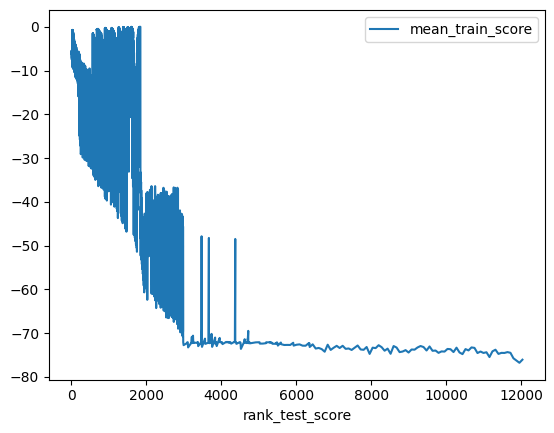

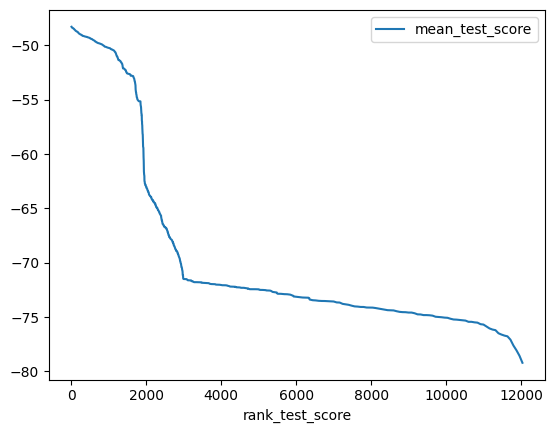

In [167]:
results_df = results_df.sort_values(by='rank_test_score', ascending=False)
results_df.plot(x='rank_test_score', y='mean_train_score')
results_df.plot(x='rank_test_score', y='mean_test_score')

C:\Users\jonas\AppData\Local\Temp\ipykernel_14780\1414838910.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=best_features, y=column_names, palette="viridis")


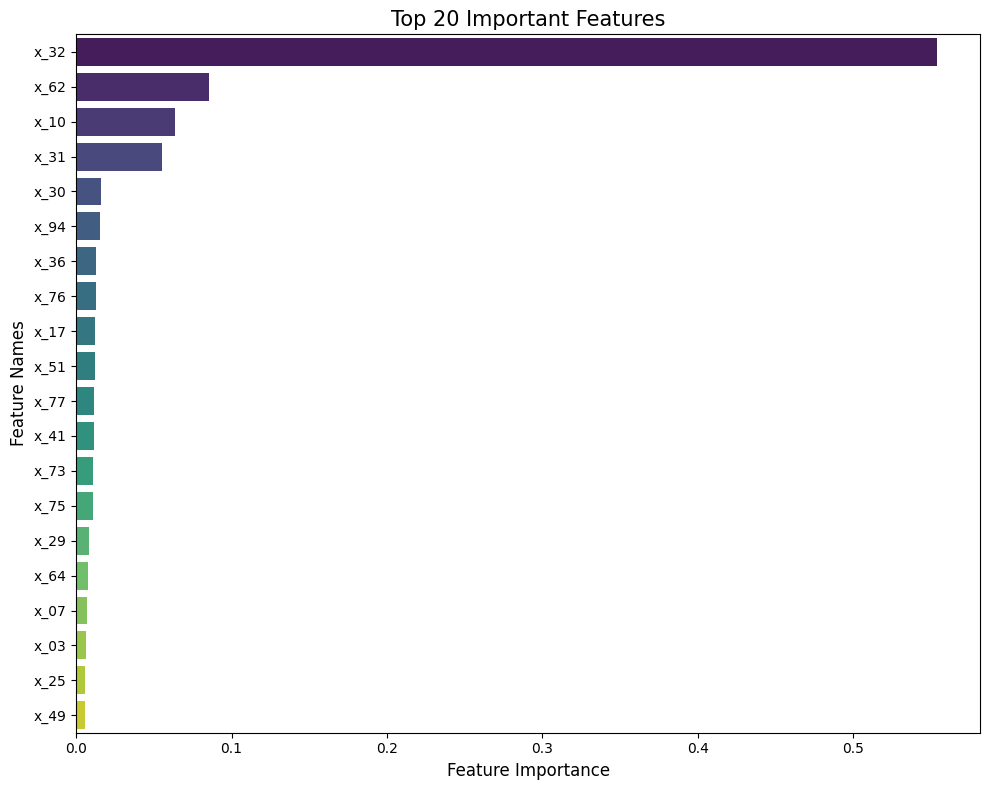

In [178]:
idx = np.argsort(best_model.feature_importances_)[::-1][:20]
best_features = best_model.feature_importances_[idx]
column_names = X.columns[idx]

# Create a horizontal bar plot for feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=best_features, y=column_names, palette="viridis")

# Add labels and title
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature Names', fontsize=12)
plt.title('Top 20 Important Features', fontsize=15)

# Show the plot
plt.tight_layout()
plt.show()


In [182]:
lasso_model = Lasso()
lasso_param_grid = {
    'alpha': np.logspace(start=-5, stop=5, num=1001),
    'random_state': [seed]
              }

lasso_best_model, lasso_best_params, lasso_results_df = grid_search(lasso_model, lasso_param_grid, X.to_numpy(), y.to_numpy())
print("Best Parameters:", lasso_best_params)


Fitting 5 folds for each of 1001 candidates, totalling 5005 fits
Best Parameters: {'alpha': 3.890451449942805, 'random_state': 42}


<Axes: xlabel='param_alpha'>

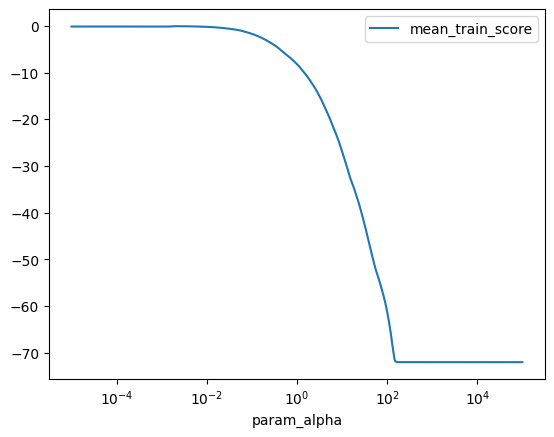

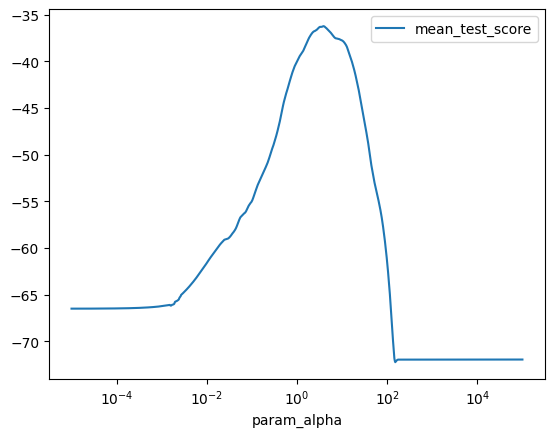

In [183]:
lasso_results_df = lasso_results_df.sort_values(by='param_alpha', ascending=False)
lasso_results_df.plot(x='param_alpha', y='mean_train_score', logx=True)
lasso_results_df.plot(x='param_alpha', y='mean_test_score', logx=True)

In [192]:
idx = [i for i, x in enumerate(lasso_best_model.coef_) if abs(x) > 0]
idx

[2,
 6,
 7,
 9,
 12,
 15,
 16,
 20,
 24,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 39,
 41,
 42,
 44,
 46,
 50,
 51,
 53,
 54,
 56,
 58,
 59,
 60,
 61,
 63,
 64,
 69,
 70,
 72,
 74,
 75,
 76,
 77,
 79,
 80,
 81,
 84,
 87,
 91,
 93]

In [90]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='test_mse', data=results_df)
plt.title('Comparison of Test MSE Across Models')
plt.xticks(rotation=45)
plt.show()

ValueError: Could not interpret value `model` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

#### Baseestimator

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import numpy as np

class PreprocessData(BaseEstimator, TransformerMixin):
    def __init__(self, num_neighbours: int = 5):
        super().__init__()
        self.num_neighbours = num_neighbours  # Fixed attribute name (was misspelled as num_neightbours in init)
    
    def fit(self, X, y=None):
        # Get category columns and dimension columns
        self.cat_columns = [x for x in X.columns if (x.startswith('C') and (X[x].nunique() != 1))]
        self.dim_columns = [x for x in X.columns if x.startswith('x')]
        
        # Initialize models
        self.knn_imputer = KNNImputer(n_neighbors=self.num_neighbours)
        self.cat_imputer = SimpleImputer(strategy='most_frequent')
        self.normalizer = StandardScaler()
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        
        # Fit the KNN imputer, scaler, and the encoder for categorical columns
        self.knn_imputer.fit(X[self.dim_columns])
        self.normalizer.fit(self.knn_imputer.transform(X[self.dim_columns]))
        
        self.cat_imputer.fit(X[self.cat_columns])
        self.encoder.fit(self.cat_imputer.transform(X[self.cat_columns]).astype(int))
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # Dimension
        X_transformed[self.dim_columns] = self.knn_imputer.transform(X_transformed[self.dim_columns])
        X_transformed[self.dim_columns] = self.normalizer.transform(X_transformed[self.dim_columns])

        # Category
        X_transformed[self.cat_columns] = self.cat_imputer.transform(X_transformed[self.cat_columns])

        # One hot encode the categorical columns
        X_encoded = self.encoder.transform(X_transformed[self.cat_columns].astype(int))
        encoded_df = pd.DataFrame(X_encoded, columns=self.encoder.get_feature_names_out(self.cat_columns))

        # Drop the original categorical columns and concatenate the encoded ones
        X_transformed = X_transformed.drop(columns=self.cat_columns).reset_index(drop=True)
        X_transformed = pd.concat([X_transformed, encoded_df], axis=1)

        return X_transformed

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha  # Regularization strength for Lasso
        
    def fit(self, X, y):
        self.lasso = Lasso(alpha=self.alpha)
        self.lasso.fit(X, y)
        
        self.selected_features = X.columns[abs(self.lasso.coef_) > 1e-10]
        return self
    
    def transform(self, X):
        # Check if there are any selected features
        if len(self.selected_features) == 0:
            # Return at least some features if none are selected by Lasso
            print("Warning: No features selected by Lasso. Using all features.")
            return X
        
        X_selected = X[self.selected_features]
        return X_selected


## Pipeline tests

#### Initial PCA tests

In [28]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np
# import polars as pl

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

X_digits, y_digits = datasets.load_digits(return_X_y=True)
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=2, refit=True)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

best_model_test = search.best_estimator_
# # Plot the PCA spectrum
# pca.fit(X_digits)

# fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
# ax0.plot(
#     np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
# )
# ax0.set_ylabel("PCA explained variance ratio")

# ax0.axvline(
#     search.best_estimator_.named_steps["pca"].n_components,
#     linestyle=":",
#     label="n_components chosen",
# )
# ax0.legend(prop=dict(size=12))

# # For each number of components, find the best classifier results
# components_col = "param_pca__n_components"
# is_max_test_score = pl.col("mean_test_score") == pl.col("mean_test_score").max()
# best_clfs = (
#     pl.LazyFrame(search.cv_results_)
#     .filter(is_max_test_score.over(components_col))
#     .unique(components_col)
#     .sort(components_col)
#     .collect()
# )
# ax1.errorbar(
#     best_clfs[components_col],
#     best_clfs["mean_test_score"],
#     yerr=best_clfs["std_test_score"],
# )
# ax1.set_ylabel("Classification accuracy (val)")
# ax1.set_xlabel("n_components")

# plt.xlim(-1, 70)

# plt.tight_layout()
# plt.show()

Best parameter (CV score=0.874):
{'logistic__C': 21.54434690031882, 'pca__n_components': 60}


In [29]:
best_model_test

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=60)),
                ('logistic',
                 LogisticRegression(C=21.54434690031882, max_iter=10000,
                                    tol=0.1))])

In [30]:
from sklearn.utils.validation import check_is_fitted

check_is_fitted(best_model_test)

check_is_fitted(best_model_test.named_steps['scaler'])
check_is_fitted(best_model_test.named_steps['pca'])
check_is_fitted(best_model_test.named_steps['logistic'])

In [31]:
best_model_test

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=60)),
                ('logistic',
                 LogisticRegression(C=21.54434690031882, max_iter=10000,
                                    tol=0.1))])

## Only sklearn objects in pipeline

#### Model selection (grid search)

In [124]:
np.linspace(0.5, 2, num=61)

array([0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675, 0.7  ,
       0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925,
       0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  , 1.125, 1.15 ,
       1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325, 1.35 , 1.375,
       1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 , 1.575, 1.6  ,
       1.625, 1.65 , 1.675, 1.7  , 1.725, 1.75 , 1.775, 1.8  , 1.825,
       1.85 , 1.875, 1.9  , 1.925, 1.95 , 1.975, 2.   ])

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.utils.validation import check_is_fitted

# Dataloading ####################################################################################
data = pd.read_csv('case1Data.csv')

X = copy.copy(data.drop(columns="C_02").iloc[:, 1:])
y = copy.copy(data['y'])

# Define Pipeline ################################################################################

def make_pipeline(X, model=Ridge()):
    cat_columns = [x for x in X.columns if (x.startswith('C') and (X[x].nunique() != 1))]
    num_columns = [x for x in X.columns if x.startswith('x')]

    cat_transformer = Pipeline(steps=[
        ('cat_imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    num_transformer = Pipeline(steps=[
        ('pre-scale', StandardScaler()),
        ('num_imputer', KNNImputer()),  # hyperparameter n_neighbours
        ('scaler', StandardScaler())
    ])

    preprocesser = ColumnTransformer(transformers=[
        ('num', num_transformer, num_columns),
        ('cat', cat_transformer, cat_columns)
    ])

    classifier = Pipeline(steps=[
        ('preprocessor', preprocesser),
        ('feature_selection', SelectFromModel(Lasso(max_iter=5000))),  # Hyperparameter alpha
        ('clf', model)
    ])
    return classifier


# Define grid search params ######################################################################
# param_grid_Ridge = {
#     'preprocessor__num__num_imputer__n_neighbors': [3, 5, 10],
#     'feature_selection__estimator__alpha': np.logspace(-1, 1, num=21, base=10),
#     'clf__alpha': np.logspace(-2, 2, num=41, base=10)
# }

param_grid_LR = {
    'preprocessor__num__num_imputer__n_neighbors': [3, 5, 7],
    'feature_selection__estimator__alpha': np.logspace(-3, 1, num=161),
    # 'clf__alpha': np.logspace(-3, 1, num=161)
}

param_grid_ridge_lasso = {
    'preprocessor__num__num_imputer__n_neighbors': [3,4,5,6,7],
    'feature_selection__estimator__alpha': np.logspace(-1, 1, num=21, base=10),
    'clf__alpha': np.logspace(-3, 1, num=21),
    'clf__max_iter': [5000]
}

param_grid_SVR = {
    # 'preprocessor__num__num_imputer__n_neighbors': [5],
    'feature_selection__estimator__alpha': np.logspace(-1, 1, num=21, base=10),
    'clf__C': np.logspace(-2, 2, num=41, base=10),
    'clf__epsilon': [0.001],
    'clf__kernel': ['linear', 'poly', 'rbf']
}

param_grid_Gradient = {
    'preprocessor__num__num_imputer__n_neighbors': [5],
    'feature_selection__estimator__alpha': [1.0],
    'clf__loss': ['squared_error', 'absolute_error'],
    'clf__learning_rate': np.logspace(-3, 0, num=4),
    'clf__n_estimators': [100, 500, 1000, 5000, 10_000],
    'clf__min_samples_split': [2, 10, 20],
    'clf__max_depth': [1, 2, 3],
    'clf__random_state': [42]
}

param_grid_RF = {
    'preprocessor__num__num_imputer__n_neighbors': [5],
    'feature_selection__estimator__alpha': [1.0],
    'clf__n_estimators': [100, 500, 1000, 5000, 10_000],
    'clf__min_samples_split': [2, 10, 20],
    'clf__max_depth': [1, 2, 3, None],
    'clf__max_features': [1/3, None],
    'clf__bootstrap': [True],
    'clf__oob_score': [True],
    'clf__random_state': [42]
}

# Run grid search for one model ##################################################################
K = 5
model = RandomForestRegressor()
# model = SVR()
model_class_name = model.__class__.__name__
if model_class_name in ['Ridge', 'Lasso']:
    print(f"Using {model_class_name}")
    param_grid = param_grid_ridge_lasso
elif model_class_name == 'SVR':
    print("Using SVR")
    param_grid = param_grid_SVR
elif model_class_name == 'LinearRegression':
    print("Using LinearRegression")
    param_grid = param_grid_LR
elif model_class_name == 'GradientBoostingRegressor':
    print("Using GradientBoosting")
    param_grid = param_grid_Gradient
elif model_class_name == 'RandomForestRegressor':
    print("Using RandomForestRegressor")
    param_grid = param_grid_RF

grid_search = GridSearchCV(make_pipeline(X, model), 
                           param_grid, 
                           cv=K, 
                           n_jobs=-1, 
                           verbose=3, 
                           scoring='neg_root_mean_squared_error', 
                           refit=True, 
                           return_train_score=False)

# Fit the model with GridSearchCV
grid_search.fit(X, y)
print('Done fitting')

# Use the best model to make predictions
best_model = grid_search.best_estimator_
best_parameters = grid_search.best_params_

# Check the best parameters and model
print("Best parameters:", best_parameters)
print("Best score:", -grid_search.best_score_)

# Check if all steps are fitted
# check_is_fitted(best_model.named_steps['imputer'])  

# y_pred = best_model.predict(X_test)
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.to_csv(f'{model_class_name}_cv_results.csv')
cv_results

Using RandomForestRegressor
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Done fitting
Best parameters: {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 10000, 'clf__oob_score': True, 'clf__random_state': 42, 'feature_selection__estimator__alpha': 1.0, 'preprocessor__num__num_imputer__n_neighbors': 5}
Best score: 45.11657597557384


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__bootstrap,param_clf__max_depth,param_clf__max_features,param_clf__min_samples_split,param_clf__n_estimators,param_clf__oob_score,...,param_preprocessor__num__num_imputer__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.242861,0.313141,0.287142,0.069456,True,1,0.333333,2,100,True,...,5,"{'clf__bootstrap': True, 'clf__max_depth': 1, ...",-56.224463,-55.478284,-74.910451,-72.808363,-45.561479,-60.996608,11.176592,118
1,5.583232,1.317005,0.478523,0.130084,True,1,0.333333,2,500,True,...,5,"{'clf__bootstrap': True, 'clf__max_depth': 1, ...",-56.906666,-55.759738,-73.799906,-71.870341,-45.993760,-60.866082,10.500621,115
2,9.273100,0.857199,0.654391,0.040378,True,1,0.333333,2,1000,True,...,5,"{'clf__bootstrap': True, 'clf__max_depth': 1, ...",-57.017727,-55.645462,-73.775821,-71.940512,-45.851601,-60.846225,10.552741,112
3,47.458892,10.363679,2.113168,0.303994,True,1,0.333333,2,5000,True,...,5,"{'clf__bootstrap': True, 'clf__max_depth': 1, ...",-56.954833,-55.830005,-73.127975,-71.709948,-45.752838,-60.675120,10.361768,106
4,87.387114,25.479493,3.939481,0.108463,True,1,0.333333,2,10000,True,...,5,"{'clf__bootstrap': True, 'clf__max_depth': 1, ...",-56.924825,-55.641993,-73.032565,-72.005344,-45.838345,-60.688614,10.398139,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1.004624,0.181047,0.203985,0.036681,True,None,None,20,100,True,...,5,"{'clf__bootstrap': True, 'clf__max_depth': Non...",-39.108739,-37.249442,-54.462092,-60.546553,-47.138478,-47.701061,8.878052,21
116,4.269551,0.390914,0.330850,0.037954,True,None,None,20,500,True,...,5,"{'clf__bootstrap': True, 'clf__max_depth': Non...",-40.427987,-38.299067,-54.597794,-61.436351,-47.809880,-48.514216,8.651288,25
117,7.541636,0.339781,0.490211,0.034594,True,None,None,20,1000,True,...,5,"{'clf__bootstrap': True, 'clf__max_depth': Non...",-40.357056,-38.526380,-54.476567,-61.237332,-48.171077,-48.553682,8.530339,26
118,36.540428,1.193462,1.693433,0.123571,True,None,None,20,5000,True,...,5,"{'clf__bootstrap': True, 'clf__max_depth': Non...",-39.968330,-38.306352,-54.642054,-61.034118,-48.144677,-48.419106,8.621164,24


In [296]:
cv_results = pd.DataFrame(grid_search.cv_results_)

#### Use 1-std rule

In [302]:
best_parameters = cv_results['params'][j]

In [300]:
import ast
for k, v in ast.literal_eval(cv_results['params'][j]).items():
    print(type(k), type(v))

ValueError: malformed node or string: {'clf__alpha': 0.0025118864315095794, 'feature_selection__estimator__alpha': 0.6309573444801934, 'preprocessor__num__num_imputer__n_neighbors': 5}

CV alpha with 1-std-rule 252.00
CV params with 1-std-rule:  {'clf__alpha': 0.0025118864315095794, 'clf__max_iter': 5000, 'feature_selection__estimator__alpha': 0.6309573444801934, 'preprocessor__num__num_imputer__n_neighbors': 5}
CV RMSE with 1-std-rule:  26.01722866175744


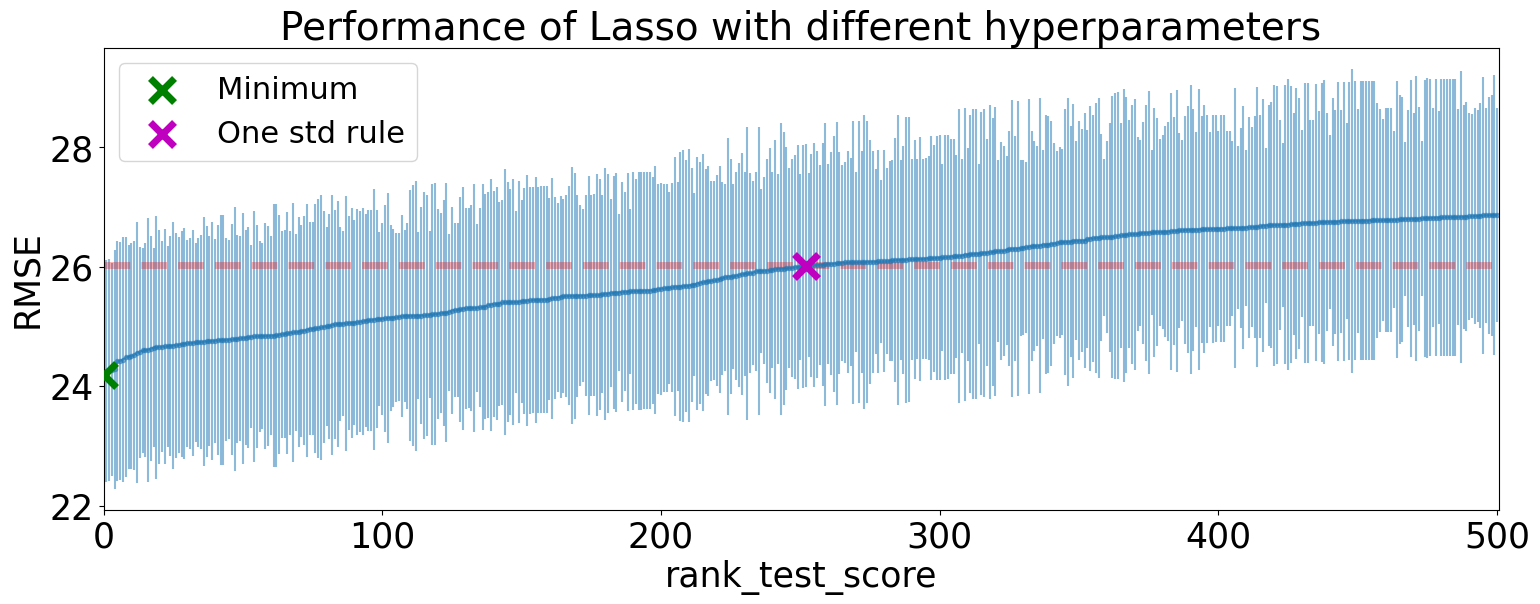

In [64]:
import ast
K=10
cv_results = pd.read_csv('Lasso_cv_results.csv')
x_name = 'rank_test_score'  # 'rank_test_score, param_clf__alpha
cv_results.sort_values(x_name, inplace=True)
ranks = cv_results[x_name].to_numpy()[:501] - 1
meanRMSE = -cv_results['mean_test_score'].to_numpy()[:501]
seRMSE = cv_results['std_test_score'].to_numpy()[:501] / np.sqrt(K)  # K = 10 folds
jOpt = np.argsort(meanRMSE)[0]

ymin, ymax = np.min(meanRMSE - seRMSE), np.max(meanRMSE + seRMSE)

J = np.where(meanRMSE[jOpt] + seRMSE[jOpt] > meanRMSE)[0]
j = int(J[-1])
rank_CV_1StdRule = ranks[j]
best_params = ast.literal_eval(cv_results['params'][j])
print("CV alpha with 1-std-rule %0.2f" % rank_CV_1StdRule)
print("CV params with 1-std-rule: ", best_params)
print("CV RMSE with 1-std-rule: ", meanRMSE[j])

fig, ax = plt.subplots(1,1,figsize=(18,6))

ax.errorbar(ranks, meanRMSE, seRMSE, marker='.', capthick=1, alpha=0.5);
ax.scatter(ranks[jOpt],meanRMSE[jOpt],c='g',marker='x',zorder=100,label='Minimum', s=300, linewidths=5)
ax.scatter(ranks[j],meanRMSE[j],c='m',marker='x',zorder=100,label='One std rule', s=300, linewidths=5)
ax.hlines(y=meanRMSE[jOpt] + seRMSE[jOpt], xmin=0, xmax=ranks[-1], colors='red', linestyle='dashed',alpha=0.3, linewidth=5)
ax.legend(loc='upper left', fontsize=22);
ax.set_xlim((ranks[0], ranks[-1]+0.5))
# ax.set_xticks(np.array([1, 100, 200, 300, 400, 500])-1)
# ax.set_xscale('log')
# ax.set_xticklabels([1, 100, 200, 300, 400, 500])
ax.tick_params(labelsize=25)
ax.set_title(f"Performance of Lasso with different hyperparameters", fontsize=28)
ax.set_xlabel(x_name.split("__")[-1], fontsize=25)
ax.set_ylabel('RMSE', fontsize=25)
plt.show()

In [20]:
len(ranks)

501

#### Predict test set

In [67]:
import ast
model = Lasso()
best_parameters = ast.literal_eval(cv_results['params'].iloc[j])
clf = make_pipeline(X, model)
clf.set_params(**best_parameters)
clf.fit(X, y)

dataNEW = pd.read_csv('case1Data_Xnew.csv')
X_NEW = copy.copy(dataNEW)
y_pred_NEW = clf.predict(X_NEW)
sample_pred_df = pd.DataFrame(y_pred_NEW)
sample_pred_df.to_csv('predictions_s204218_s204225.csv', header=False, index=False)

(array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]),
 [Text(0, 0.0, '0.000'),
  Text(0, 0.001, '0.001'),
  Text(0, 0.002, '0.002'),
  Text(0, 0.003, '0.003'),
  Text(0, 0.004, '0.004'),
  Text(0, 0.005, '0.005'),
  Text(0, 0.006, '0.006'),
  Text(0, 0.007, '0.007')])

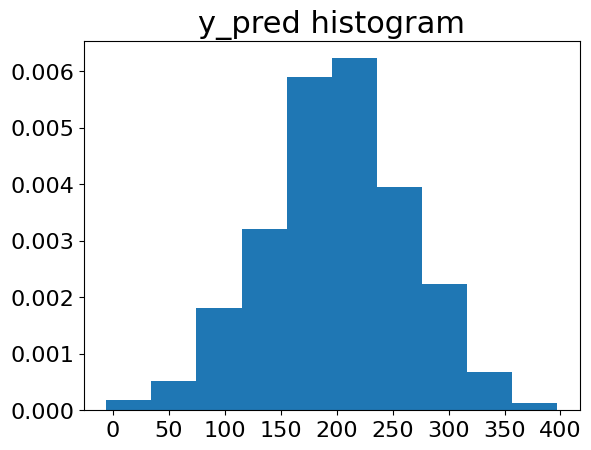

In [63]:
plt.hist(y_pred_NEW, density=True)
plt.title("y_pred histogram", fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]),
 [Text(0, 0.0, '0.000'),
  Text(0, 0.001, '0.001'),
  Text(0, 0.002, '0.002'),
  Text(0, 0.003, '0.003'),
  Text(0, 0.004, '0.004'),
  Text(0, 0.005, '0.005'),
  Text(0, 0.006, '0.006'),
  Text(0, 0.007, '0.007')])

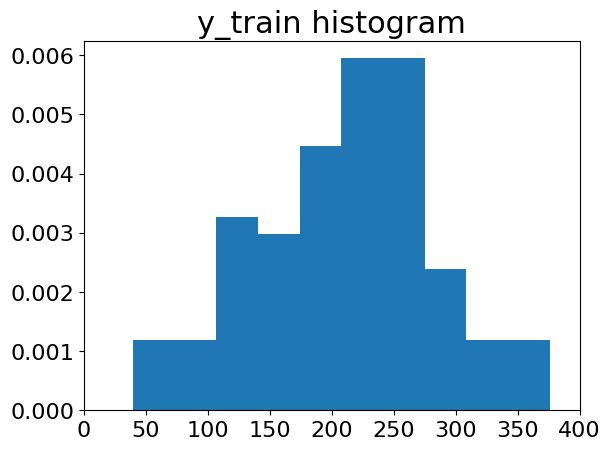

In [41]:
plt.hist(y, density=True)
plt.title("y_train histogram", fontsize=22)
plt.xlim(0, 400)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#### Model assesment

In [45]:
clf = make_pipeline(X, Lasso())

clf.set_params(**best_parameters)
clf.fit(X, y)
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('pre-scale',
                                                                   StandardScaler()),
                                                                  ('num_imputer',
                                                                   KNNImputer(n_neighbors=4)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['x_01', 'x_02', 'x_03',
                                                   'x_04', 'x_05', 'x_06',
                                                   'x_07', 'x_08', 'x_09',
                                                   'x_10', 'x_11', 'x_12',
                                                   'x_13', 'x_14', 'x_15',
                                                   'x_16', 'x_17', 'x_18',
                                                   'x_19', 'x_20', 'x_21',
                                                   'x_22', 'x_23...
                                                   'x_28', 'x_29', 'x_30', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['C_01', 'C_03', 'C_04',
                                                   'C_05'])])),
                ('feature_selection',
                 SelectFromModel(estimator=Lasso(alpha=1.2589254117941675,
                                                 max_iter=5000))),
                ('clf', Lasso(alpha=1.584893192461114, max_iter=5000))])

<Axes: >

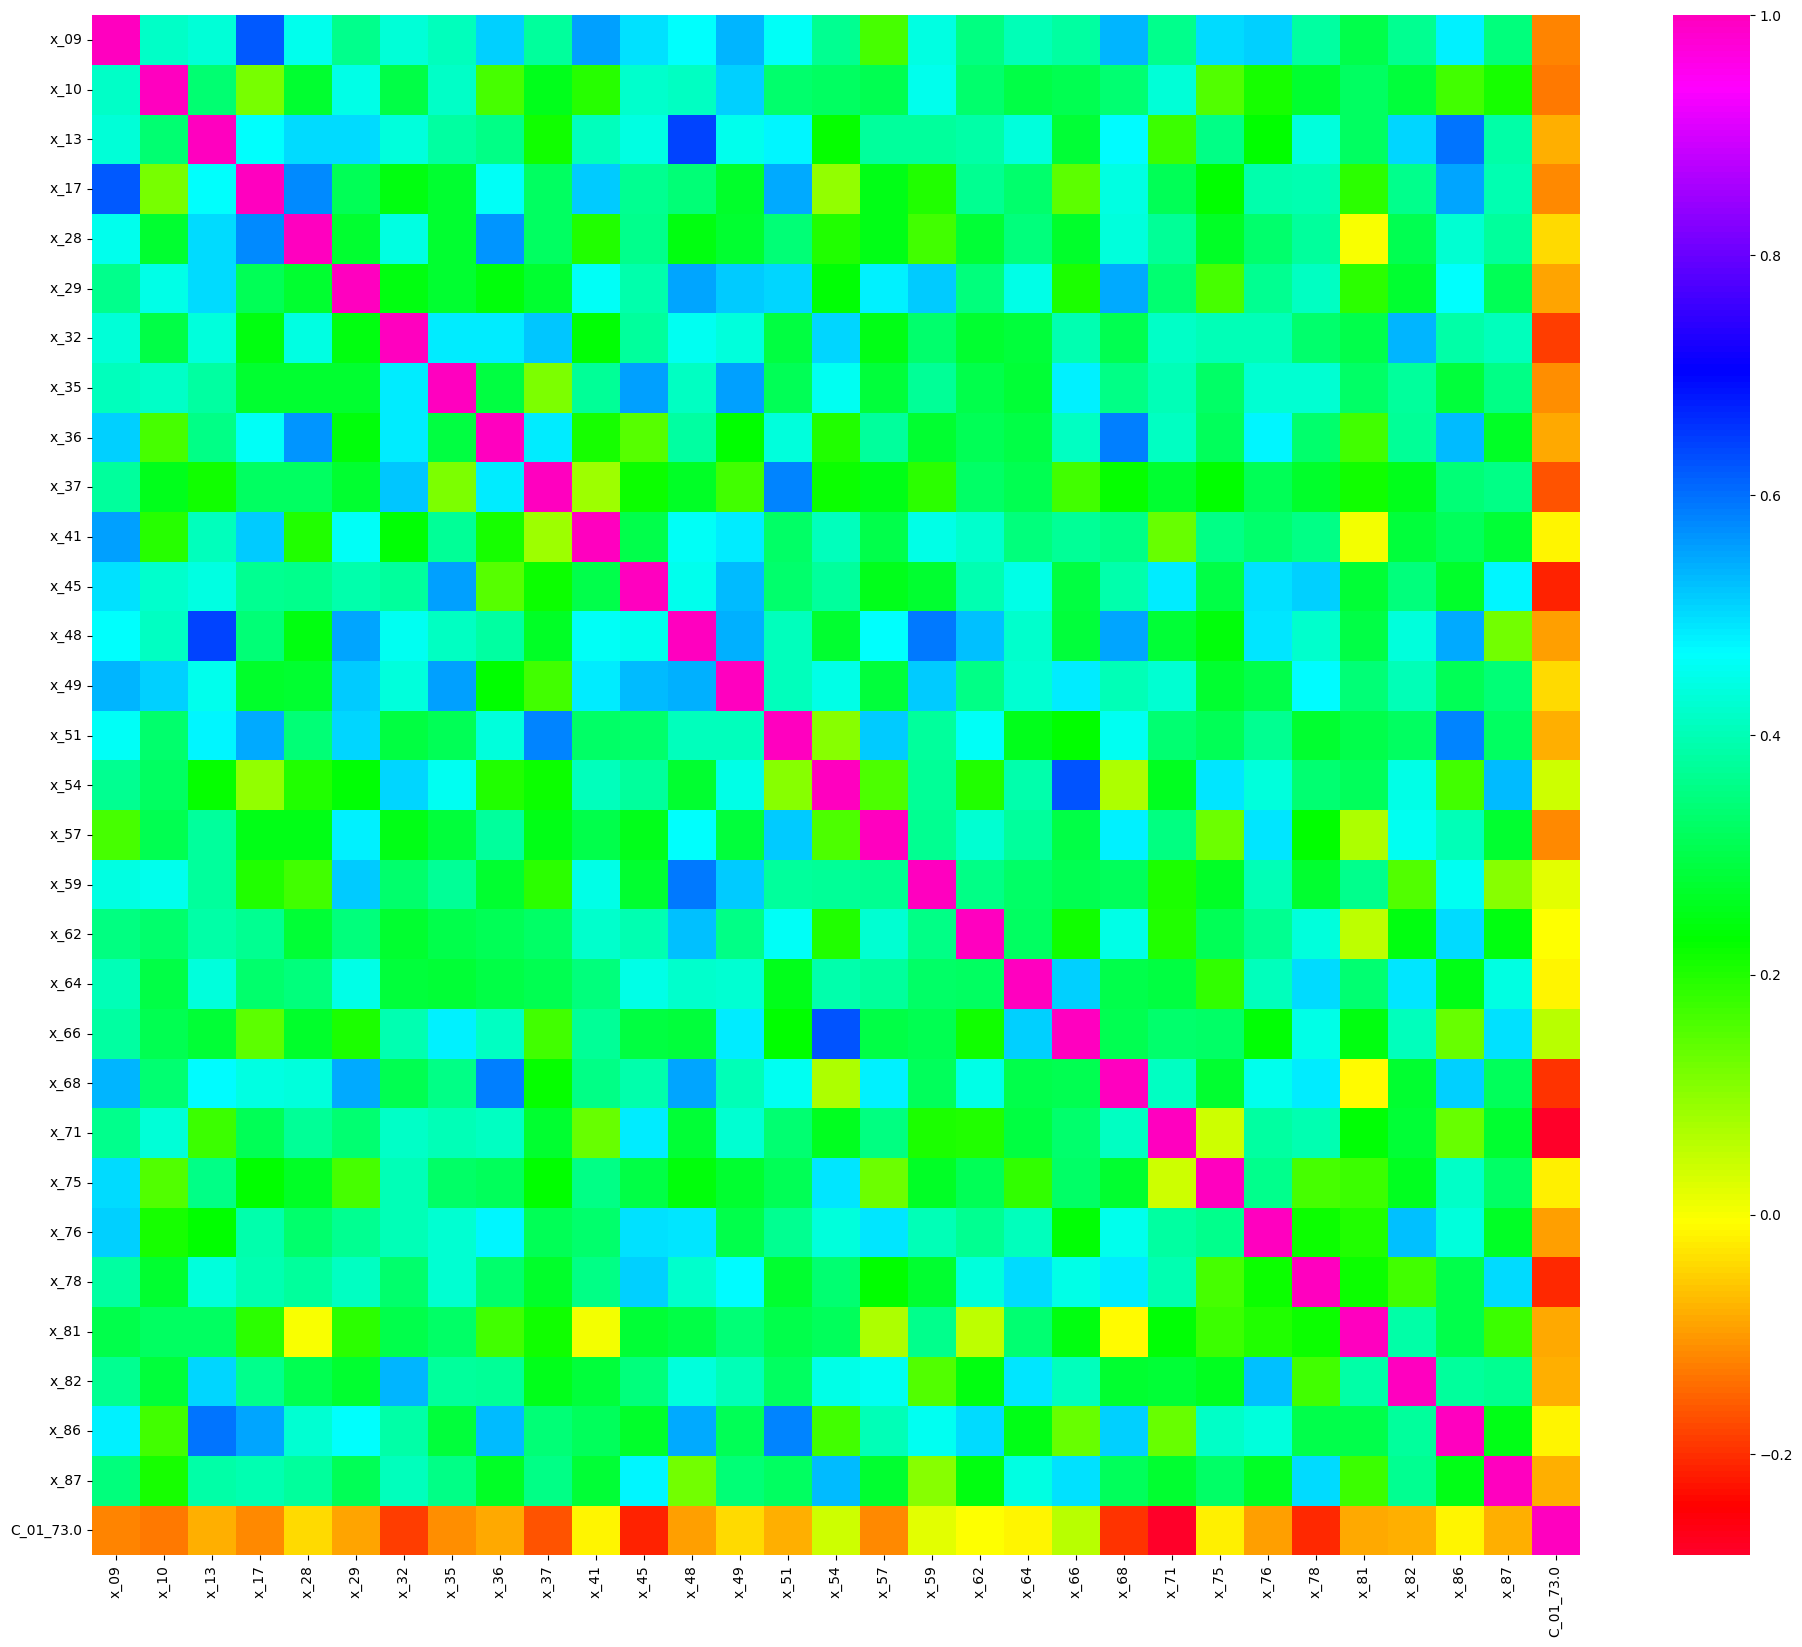

In [60]:
feature_names = [s.split('__')[-1] for s in clf[:-1].get_feature_names_out()]
X_t = pd.DataFrame(clf[:-1].transform(X), columns=feature_names)
fig, ax = plt.subplots(1, 1, figsize=(24,20))
sns.heatmap(X_t.corr(), ax=ax, cmap="gist_rainbow")

In [52]:
clf[0]

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('pre-scale',
                                                  StandardScaler()),
                                                 ('num_imputer',
                                                  KNNImputer(n_neighbors=4)),
                                                 ('scaler', StandardScaler())]),
                                 ['x_01', 'x_02', 'x_03', 'x_04', 'x_05',
                                  'x_06', 'x_07', 'x_08', 'x_09', 'x_10',
                                  'x_11', 'x_12', 'x_13', 'x_14', 'x_15',
                                  'x_16', 'x_17', 'x_18', 'x_19', 'x_20',
                                  'x_21', 'x_22', 'x_23', 'x_24', 'x_25',
                                  'x_26', 'x_27', 'x_28', 'x_29', 'x_30', ...]),
                                ('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['C_01', 'C_03', 'C_04', 'C_05'])])

<Axes: >

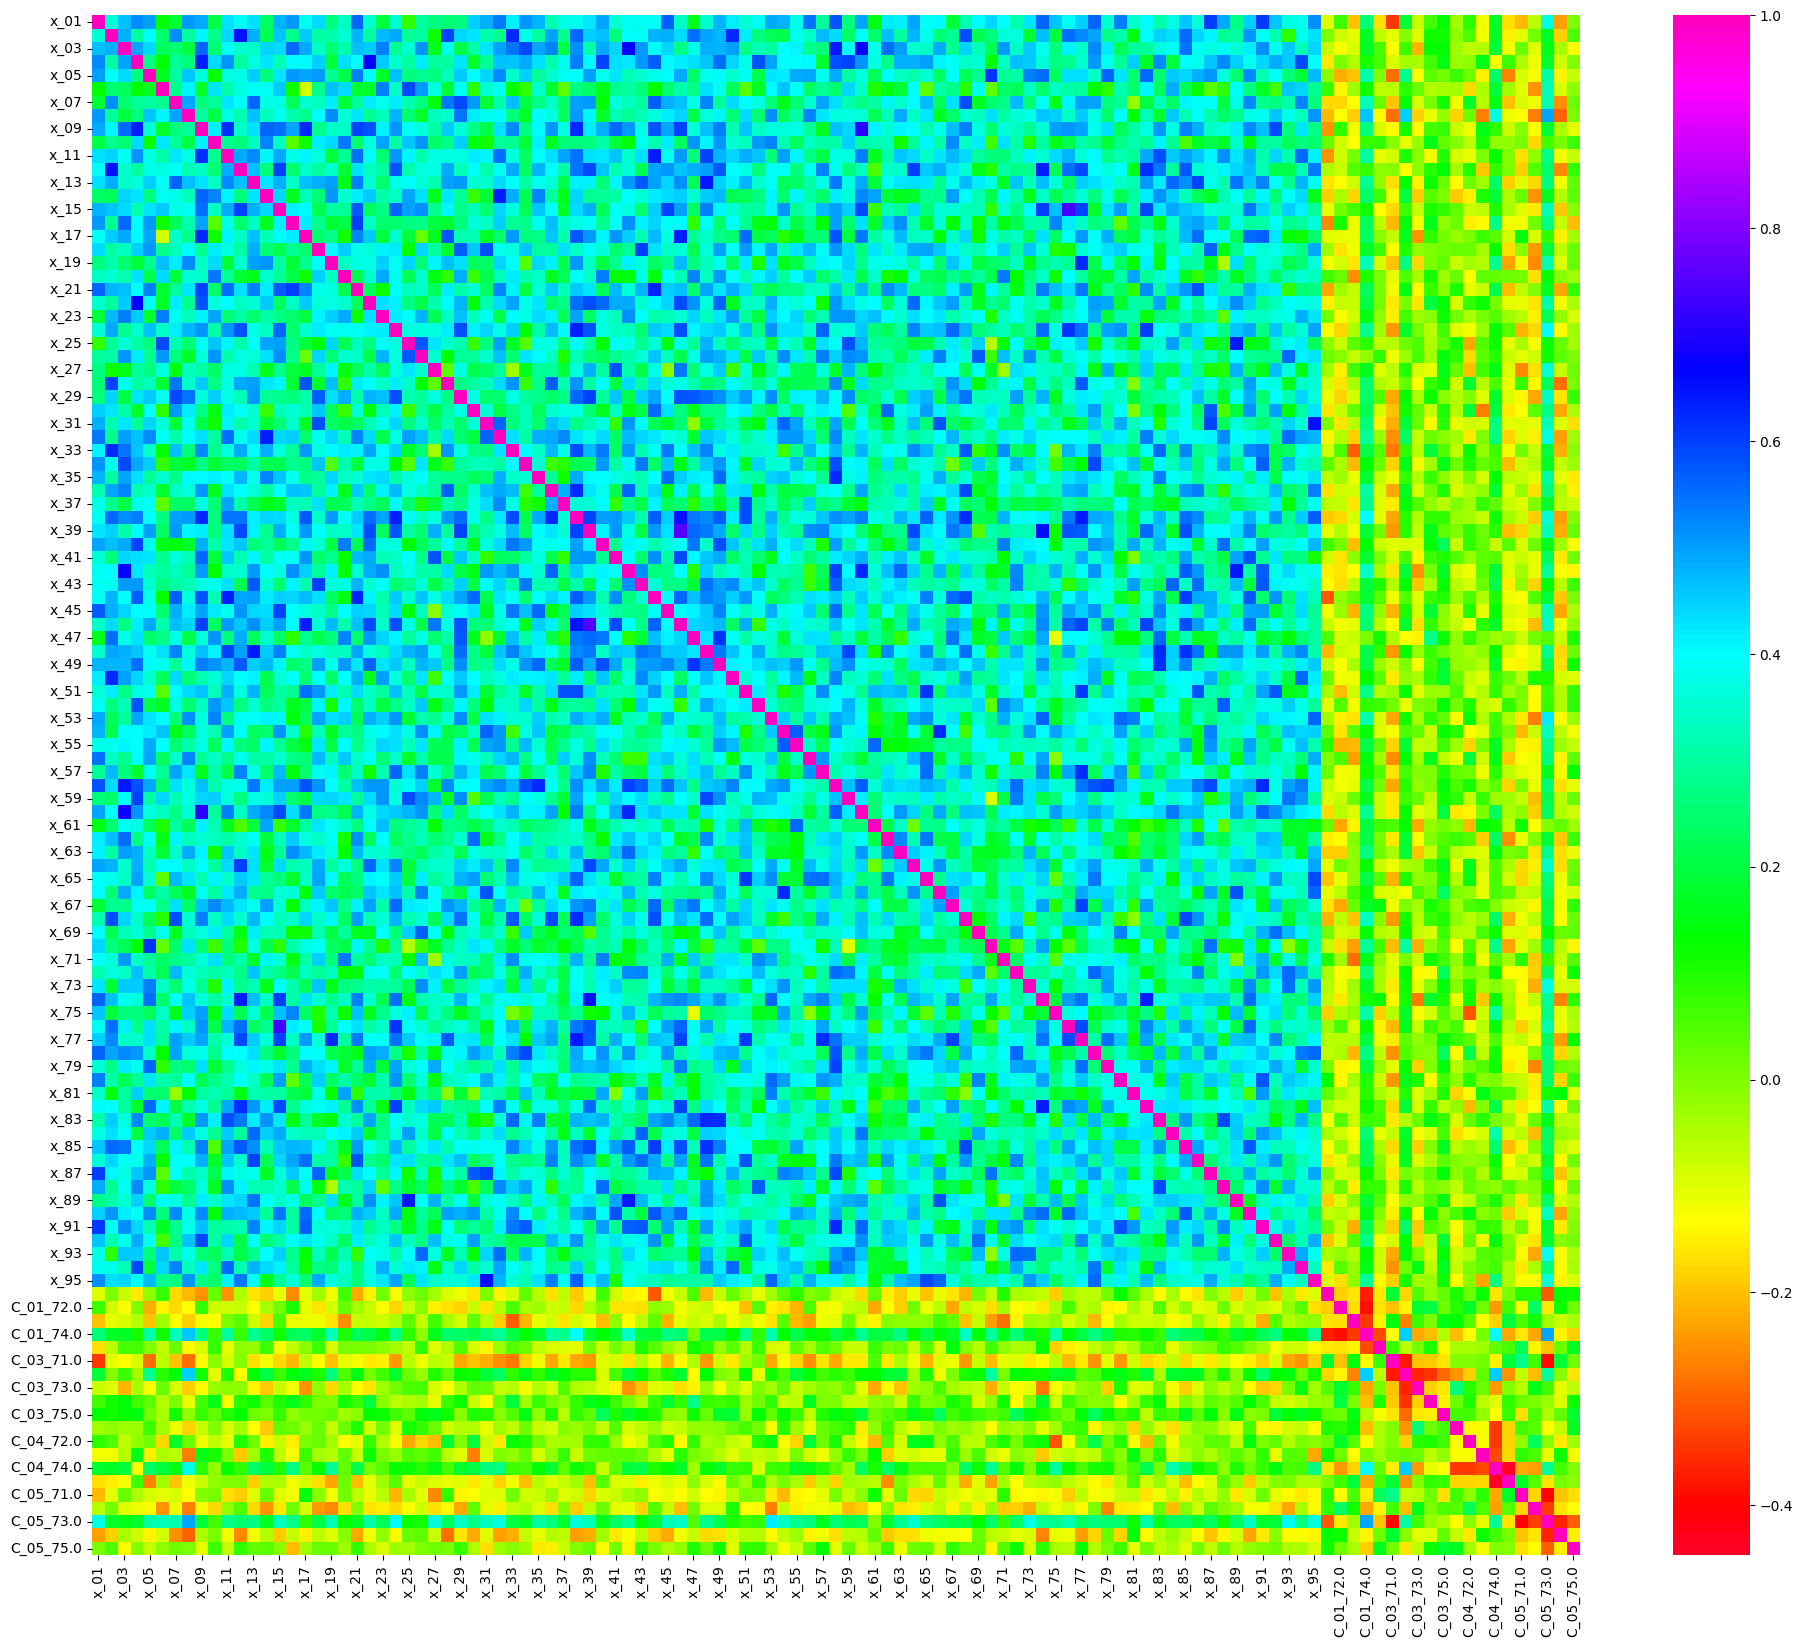

In [59]:
preproc_feature_names = [s.split('__')[-1] for s in clf[0].get_feature_names_out()]
X_t = pd.DataFrame(clf[0].transform(X), columns=preproc_feature_names)
fig, ax = plt.subplots(1, 1, figsize=(24,20))
sns.heatmap(X_t.corr(), ax=ax, cmap="gist_rainbow")

##### Boostrap

In [ ]:
from sklearn.metrics import root_mean_squared_error
B = 5_000  # Number of boostrap samples
model = Lasso()
n, p = X.shape

rng = np.random.default_rng(seed=42)

# Instantieate new model
clf = make_pipeline(X, model)
clf.set_params(**best_parameters)
rmse = []
rmse_plot = []
rmse_std_plot = []
for i in range(B):
    if (i+1) % (0.2 * B) == 0:
        print(f"Bootstap iteration: {i+1}")
    # Get boostrap samples. Continue to sample while oob samples are not empty
    empty_oob = True
    while empty_oob:
        bootstrap_idx = rng.choice(n, size=n, replace=True)
        oob_idx = np.setdiff1d(np.arange(n), bootstrap_idx)
        
        Z_train = copy.copy(X.iloc[bootstrap_idx, :])
        y_train = copy.copy(y.iloc[bootstrap_idx])
        
        Z_test = copy.copy(X.iloc[oob_idx, :])
        y_test = copy.copy(y.iloc[oob_idx])
        
        if len(Z_test) != 0:  # oob is not empty, we can continue
            empty_oob = False
    
    # Fit model to boostrap samples
    clf.fit(Z_train, y_train)
    
    # Get prediction
    y_pred = clf.predict(Z_test)
    
    # Calculate RMSE
    rmse_score = root_mean_squared_error(y_test, y_pred)
    rmse.append(rmse_score)
    
    if (i+1) % 100 == 0:
        rmse_plot.append(np.mean(rmse))
        rmse_std_plot.append(np.std(rmse))

print(f"Expected RMSE (with B={B}): {np.mean(rmse)} +/- {np.std(rmse)}")
pd.DataFrame([np.mean(rmse)]).to_csv('estimated_RMSE_s204218_s204225.csv', header=False, index=False)
# plt.errorbar(range(len(rmse_plot))*100, rmse_plot, rmse_std_plot)
# plt.show()

Bootstap iteration: 1000
Bootstap iteration: 2000
Bootstap iteration: 3000
Bootstap iteration: 4000
Bootstap iteration: 5000
Expected RMSE (with B=5000): 33.25232560161373 +/- 4.407538809126392


TypeError: unsupported operand type(s) for *: 'range' and 'int'

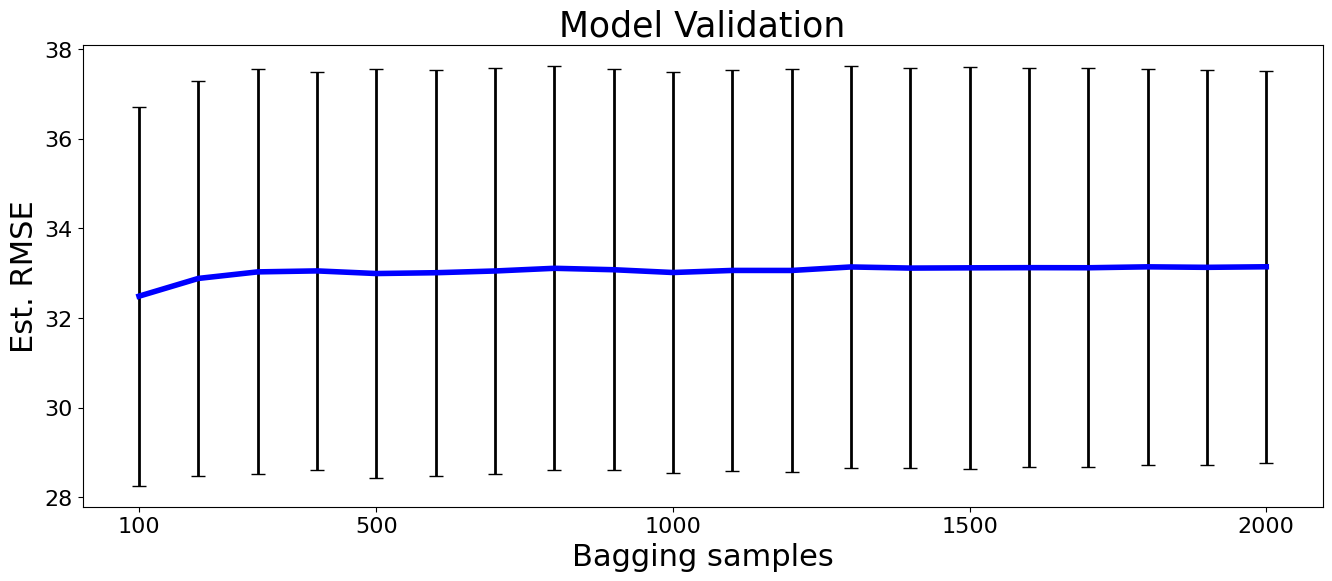

In [100]:
xx = np.arange(len(rmse_plot)+1)[1:21]*100
plt.figure(figsize=(16,6))
plt.errorbar(x=xx, y=rmse_plot[:len(xx)], yerr=rmse_std_plot[:len(xx)], ls='--', elinewidth=2, color='k', capthick=1, capsize=5)
plt.plot(xx, rmse_plot[:len(xx)], 'b', linewidth=4, zorder=20)
plt.xlabel('Bagging samples', fontsize=22)
plt.ylabel('Est. RMSE', fontsize=22)
plt.title('Model Validation', fontsize=25)
# plt.xlim(50, 5000)
# plt.xticks(ticks=[100, 1000, 2000, 3000, 4000, 5000], fontsize=16)
plt.xticks(ticks=[100, 500, 1000, 1500, 2000], fontsize=16)
plt.yticks(fontsize=16)
plt.show()

##### CV estimate

In [331]:
from sklearn.model_selection import cross_val_score
model = Lasso()
n, p = X.shape
cv_scores = cross_val_score(make_pipeline(X, model), X, y, cv=n, scoring='neg_root_mean_squared_error')
cv_rmse = np.mean(-cv_scores)  # Convert to positive RMSE
print(f"Mean CV RMSE: {cv_rmse:.4f}")

pd.DataFrame([cv_rmse]).to_csv('estimated_RMSE_s204218_s204225.csv', header=False, index=False)

Mean CV RMSE: 19.4263


In [165]:
best_model.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('pre-scale',
                                                   StandardScaler()),
                                                  ('num_imputer', KNNImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['x_01', 'x_02', 'x_03', 'x_04', 'x_05',
                                   'x_06', 'x_07', 'x_08', 'x_09', 'x_10',
                                   'x_11', 'x_12', 'x_13', 'x_14', 'x_15',
                                   'x_16', 'x_17', 'x_18', 'x_19', 'x_20',
                                   'x_21', 'x_22', 'x_23', 'x_24', 'x_25',
                                   'x_26', 'x_27', 'x_28', 'x_29', 'x_30', ...]),
                                 ('cat',
                                  Pipeline(steps=[('cat_imputer',
                                                   SimpleImputer(strategy='most_fr

In [201]:
clf['clf'].feature_names_in_

AttributeError: 'Lasso' object has no attribute 'feature_names_in_'

In [183]:
clf.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('pre-scale',
                                                   StandardScaler()),
                                                  ('num_imputer', KNNImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['x_01', 'x_02', 'x_03', 'x_04', 'x_05',
                                   'x_06', 'x_07', 'x_08', 'x_09', 'x_10',
                                   'x_11', 'x_12', 'x_13', 'x_14', 'x_15',
                                   'x_16', 'x_17', 'x_18', 'x_19', 'x_20',
                                   'x_21', 'x_22', 'x_23', 'x_24', 'x_25',
                                   'x_26', 'x_27', 'x_28', 'x_29', 'x_30', ...]),
                                 ('cat',
                                  Pipeline(steps=[('cat_imputer',
                                                   SimpleImputer(strategy='most_fr

In [214]:
X_t = clf[:-1].transform(X)

In [234]:
sum(abs(clf[-2].estimator_.coef_) > 0)

33

In [236]:
sum(abs(clf[-1].coef_) > 0)

28

In [215]:
X_t.shape

(100, 33)